For a number of years now, I have been interesting in using Bayesian [item-response theory](https://en.wikipedia.org/wiki/Item_response_theory) (IRT) models to quantify skills in professional sports.  In 2017 and 2018, I published two posts ([first](https://austinrochford.com/posts/2017-04-04-nba-irt.html), [second](https://austinrochford.com/posts/2018-02-04-nba-irt-2.html)) exploring the NBA's [Last Two Minute Reports](https://official.nba.com/2024-25-nba-officiating-last-two-minute-reports/), the leagues assessment of officiating performance in the last two minutes of close games. Those posts developed IRT models that used the Last Two Minute Report data to quantify the skill of NBA players in drawing and committing fouls.

After writing these posts, I was looking for other similar applications and discovered the delightful [hockeyfights.com](https://www.hockeyfights.com/), a site that gathers videos of and data about fights in various hockey leagues, including the NHL.  The most interesting feature of this site for my purposes is that it allows visitors to vote on which player won the fight, or whether it was a draw.

<center>
    <figure>
        <img width=400 src="https://austinrochford.com/resources/nhl/n271982.png">
        <figcaption>Example <a href="https://www.hockeyfights.com/fights/n271982">page</a> for Oct 15, 2025 fight between Adam Klapka and Jack McBain</figcaption>
    </figure>
</center>

This voting data provides information we will use to develop a Bayesian IRT model to quantify fighting skill among NHL players and teams.  The rest of this post will systematically develop that model using [PyMC](https://www.pymc.io/welcome.html), starting with a very simple model and gradually enlarging it until we can answer the question: is fighting a skill that persists over time for players and/or teams?

Before diving in, we make some Python imports and do some light configuration.

In [1]:
%matplotlib inline

In [2]:
import textwrap
from warnings import filterwarnings

In [3]:
import arviz as az
from matplotlib import patches, pyplot as plt, rcParams, ticker
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from numba import NumbaPerformanceWarning
import numpy as np
import nutpie
import pandas as pd
import polars as pl
import pymc as pm
from pytensor import tensor as pt
import seaborn as sns
from seaborn import objects as so

In [4]:
filterwarnings("ignore", category=NumbaPerformanceWarning)
filterwarnings("ignore", category=RuntimeWarning, module="arviz")
filterwarnings("ignore", category=UserWarning, module="arviz")

In [5]:
FIG_WIDTH = 8
FIG_HEIGHT = 6
rcParams["figure.figsize"] = (FIG_WIDTH, FIG_HEIGHT)

SIDE_BY_SIDE_FIGSIZE = (1.5 * FIG_WIDTH, 0.8 * FIG_HEIGHT)


def pct_formatter(dec=0):
    return ticker.StrMethodFormatter(f"{{x:.{dec}%}}")


def wrap(text, width=40):
    return "\n".join(textwrap.wrap(text, width=width))


pct_locator = ticker.MultipleLocator(0.25)
season_locator = ticker.MultipleLocator(3, 2014)

sns.set(color_codes=True)

## Loading the data

Data for the 2010-2024 NHL seasons was scraped from hockeyfights.com.  Many thanks to that site's administrators for operating the service and collecting such an interesting data set over the years. (Throughout this post we will refer to NHL seasons by the calendar year in which they began.)

First we load the data into a [Polars](https://pola.rs/) dataframe.

In [6]:
DATA_PATH = "https://austinrochford.com/resources/nhl/2010-20251011-fights.csv.gz"

In [7]:
full_df = (
    pl.read_csv(DATA_PATH, try_parse_dates=True)
    .sort("date")
    .rename(lambda s: s.replace("left", "away").replace("right", "home"))
)

In [8]:
full_df

shape: (5_284, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ date      ┆ period    ┆ time_elap ┆ away_play ┆ … ┆ draw_vote ┆ url       ┆ season_st ┆ season_e │
│ ---       ┆ ---       ┆ sed       ┆ er        ┆   ┆ s         ┆ ---       ┆ art       ┆ nd       │
│ date      ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ i64       ┆           ┆ i64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-10-0 ┆ 2nd       ┆ 11:52     ┆ Tim       ┆ … ┆ 68        ┆ https://w ┆ 2010      ┆ 2011     │
│ 7         ┆ Period    ┆           ┆ Jackman   ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2010-10-0 ┆ 2nd       ┆ 14:09     ┆ Brett     ┆ … ┆ 14        ┆ https://w ┆ 2010      ┆ 2011     │
│ 7         ┆ Period    ┆           ┆ Sutter    ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2010-10-0 ┆ 1st       ┆ 5:53      ┆ Stefan    ┆ … ┆ 26        ┆ https://w ┆ 2010      ┆ 2011     │
│ 7         ┆ Period    ┆           ┆ Meyer     ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2010-10-0 ┆ 3rd       ┆ 17:40     ┆ Raitis    ┆ … ┆ 2         ┆ https://w ┆ 2010      ┆ 2011     │
│ 7         ┆ Period    ┆           ┆ Ivanans   ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2010-10-0 ┆ 3rd       ┆ 7:41      ┆ Corey     ┆ … ┆ 66        ┆ https://w ┆ 2010      ┆ 2011     │
│ 8         ┆ Period    ┆           ┆ Perry     ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2025-04-1 ┆ 3rd       ┆ 2:45      ┆ Alex Tuch ┆ … ┆ 2         ┆ https://w ┆ 2024      ┆ 2025     │
│ 2         ┆ Period    ┆           ┆           ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2025-04-1 ┆ 2nd       ┆ 11:53     ┆ Ryan      ┆ … ┆ 2         ┆ https://w ┆ 2024      ┆ 2025     │
│ 2         ┆ Period    ┆           ┆ Leonard   ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2025-04-1 ┆ 2nd       ┆ 13:48     ┆ Rasmus    ┆ … ┆ 19        ┆ https://w ┆ 2024      ┆ 2025     │
│ 2         ┆ Period    ┆           ┆ Sandin    ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2025-04-1 ┆ 1st       ┆ 1:14      ┆ Math

This dataframe has the following columns:

In [9]:
full_df.collect_schema()

Schema([('date', Date),
        ('period', String),
        ('time_elapsed', String),
        ('away_player', String),
        ('home_player', String),
        ('away_team', String),
        ('home_team', String),
        ('away_votes', Int64),
        ('home_votes', Int64),
        ('draw_votes', Int64),
        ('url', String),
        ('season_start', Int64),
        ('season_end', Int64)])

* `date` - the date on which the fight occurred,
* `period` - the period of the game during which the fight occurred,
* `time_elapsed` - the time elapsed in the period of the game at which the fight occurred,
* `away_player` - the player on the away team involved in the fight,
* `home_player` - the player on the home team involved in the fight,
* `away_team` - the away team for the game,
* `home_player` - the home team for the game,
* `away_votes` - the number of voter that believe the away player won the fight,
* `draw_votes` - the number of voter that believe the fight was a draw,
* `home_votes` - the number of voter that believe the home player won the fight,
* `url` - the URL of the fight's page on hockeyfights.com,
* `season_start` - the calendar year in which the season the fight occurred in began, and
* `season_end` - the calendar year in which the season the fight occurred in ended.

We see that there is no missing data.

In [10]:
assert (full_df.null_count() == 0).to_numpy().all()

We will start our analysis after the [2012-2013 lockout](https://en.wikipedia.org/wiki/2012%E2%80%9313_NHL_lockout) and include all seasons up to the most recent complete one that started in 2024.

In [11]:
df = full_df.filter(pl.col("season_start").is_between(2013, 2024))

In [12]:
df

shape: (3_746, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ date      ┆ period    ┆ time_elap ┆ away_play ┆ … ┆ draw_vote ┆ url       ┆ season_st ┆ season_e │
│ ---       ┆ ---       ┆ sed       ┆ er        ┆   ┆ s         ┆ ---       ┆ art       ┆ nd       │
│ date      ┆ str       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
│           ┆           ┆ str       ┆ str       ┆   ┆ i64       ┆           ┆ i64       ┆ i64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2013-10-0 ┆ 2nd       ┆ 17:40     ┆ Chris     ┆ … ┆ 0         ┆ https://w ┆ 2013      ┆ 2014     │
│ 1         ┆ Period    ┆           ┆ Thorburn  ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2013-10-0 ┆ 2nd       ┆ 17:10     ┆ Mark      ┆ … ┆ 41        ┆ https://w ┆ 2013      ┆ 2014     │
│ 1         ┆ Period    ┆           ┆ Fraser    ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2013-10-0 ┆ 3rd       ┆ 2:34      ┆ Colton    ┆ … ┆ 77        ┆ https://w ┆ 2013      ┆ 2014     │
│ 1         ┆ Period    ┆           ┆ Orr       ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2013-10-0 ┆ 2nd       ┆ 4:25      ┆ Colton    ┆ … ┆ 38        ┆ https://w ┆ 2013      ┆ 2014     │
│ 1         ┆ Period    ┆           ┆ Orr       ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2013-10-0 ┆ 3rd       ┆ 2:34      ┆ Carter    ┆ … ┆ 1         ┆ https://w ┆ 2013      ┆ 2014     │
│ 1         ┆ Period    ┆           ┆ Ashton    ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2025-04-1 ┆ 3rd       ┆ 2:45      ┆ Alex Tuch ┆ … ┆ 2         ┆ https://w ┆ 2024      ┆ 2025     │
│ 2         ┆ Period    ┆           ┆           ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2025-04-1 ┆ 2nd       ┆ 11:53     ┆ Ryan      ┆ … ┆ 2         ┆ https://w ┆ 2024      ┆ 2025     │
│ 2         ┆ Period    ┆           ┆ Leonard   ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2025-04-1 ┆ 2nd       ┆ 13:48     ┆ Rasmus    ┆ … ┆ 19        ┆ https://w ┆ 2024      ┆ 2025     │
│ 2         ┆ Period    ┆           ┆ Sandin    ┆   ┆           ┆ ww.hockey ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ fights.co ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆           ┆ m/f…      ┆           ┆          │
│ 2025-04-1 ┆ 1st       ┆ 1:14      ┆ Math

We see that there is data for over 3,700 fights for our analysis.

We now do some light feature engineering to convert teams and players into indices we can use in our models.

In [13]:
teams = pl.Enum(sorted(set(df["away_team"]) | set(df["home_team"])))
players = pl.Enum(sorted(set(df["away_player"]) | set(df["home_player"])))

In [14]:
df = df.cast(
    {
        "away_team": teams,
        "home_team": teams,
        "away_player": players,
        "home_player": players,
    }
)

In [15]:
seasons = df["season_start"].unique().sort().to_numpy()

## Exploratory data analysis

We now visualize various aspects of the data to gain familarity with it before building our models.

### Number of fights per season

Here we plot the number of fights in each season.

In [16]:
fight_ct_plot = (
    so.Plot(df["season_start"])
    .add(so.Line(), so.Count())
    .label(x="Season", y="Number of fights")
)

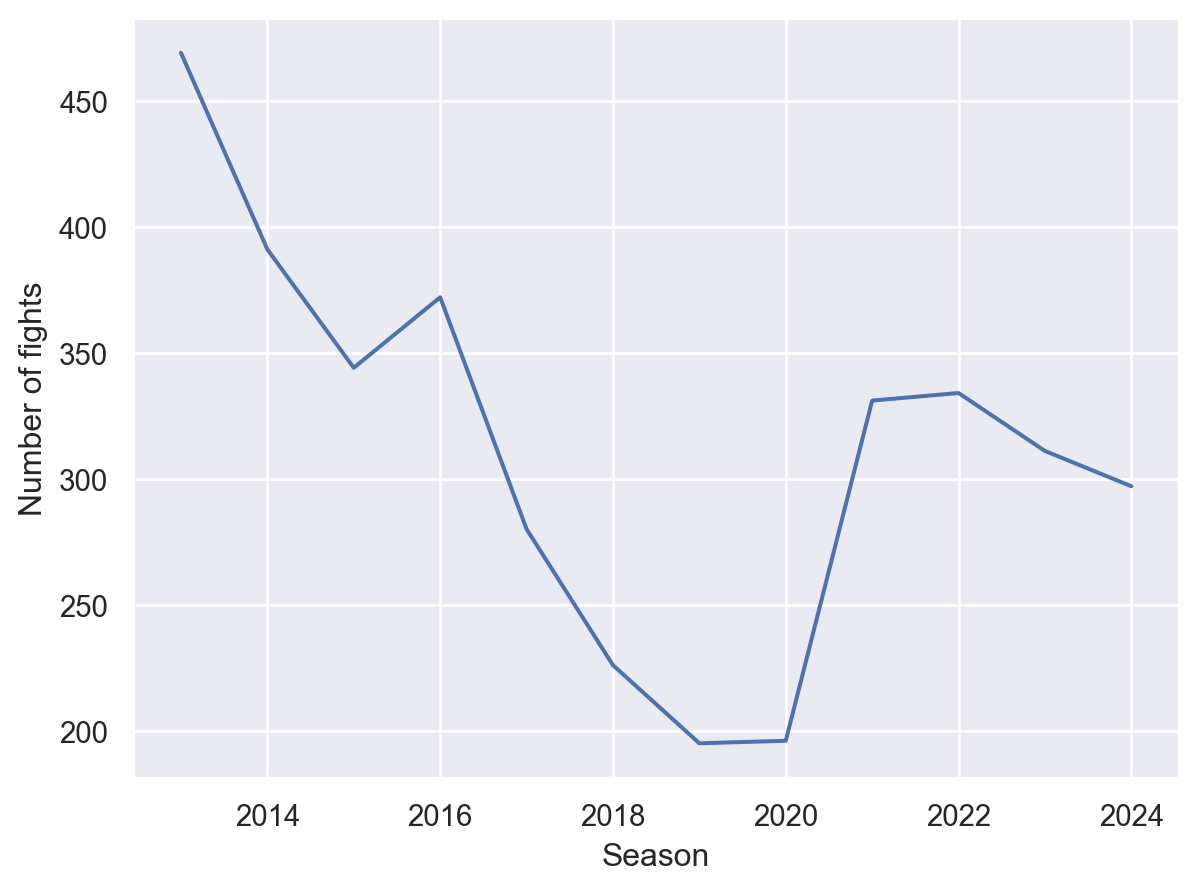

In [17]:
fight_ct_plot

We see a fair amount of variation in the number of fights year-over-year, some of which may be due to the number of games played in each season.

The NHL expanded twice during this time period, adding the [Las Vegas Golden Knights](https://www.nhl.com/goldenknights/) in the 2017-2018 season and the [Seattle Kraken](https://www.nhl.com/kraken/) in the 2021-2022 season.  Except for the COVID-shortened 2019-2020 and 2020-2021 seasons, each team played 82 games per season over the time period in question.  During the [2019-2020 season](https://en.wikipedia.org/wiki/2019%E2%80%9320_NHL_season#Standings), there were 1,082 games played, and during the [2020-2021 season](https://en.wikipedia.org/wiki/Impact_of_the_COVID-19_pandemic_on_ice_hockey#2020%E2%80%9321_season) each team played 56 games.

Using this information, we build a data frame containing the number of games played in each season.

In [18]:
season_df = (
    pl.DataFrame({"season_start": df["season_start"].unique()})
    .with_columns(
        team_ct=pl.when(pl.col("season_start") <= 2016)
        .then(30)
        .when(pl.col("season_start").is_between(2017, 2020))
        .then(31)
        .when(pl.col("season_start") >= 2021)
        .then(32)
    )
    .with_columns(
        game_ct=pl.when(pl.col("season_start") == 2019)
        .then(1082)
        .when(pl.col("season_start") == 2020)
        .then(pl.col("team_ct") * 56 / 2)
        .otherwise(pl.col("team_ct") * 82 / 2)
    )
    .join(
        df.group_by("season_start").agg(pl.len().alias("fight_ct")), on="season_start"
    )
)

As expected, we see the number of games per season grow as the league expands over time, except for the COVID-shortened seasons.

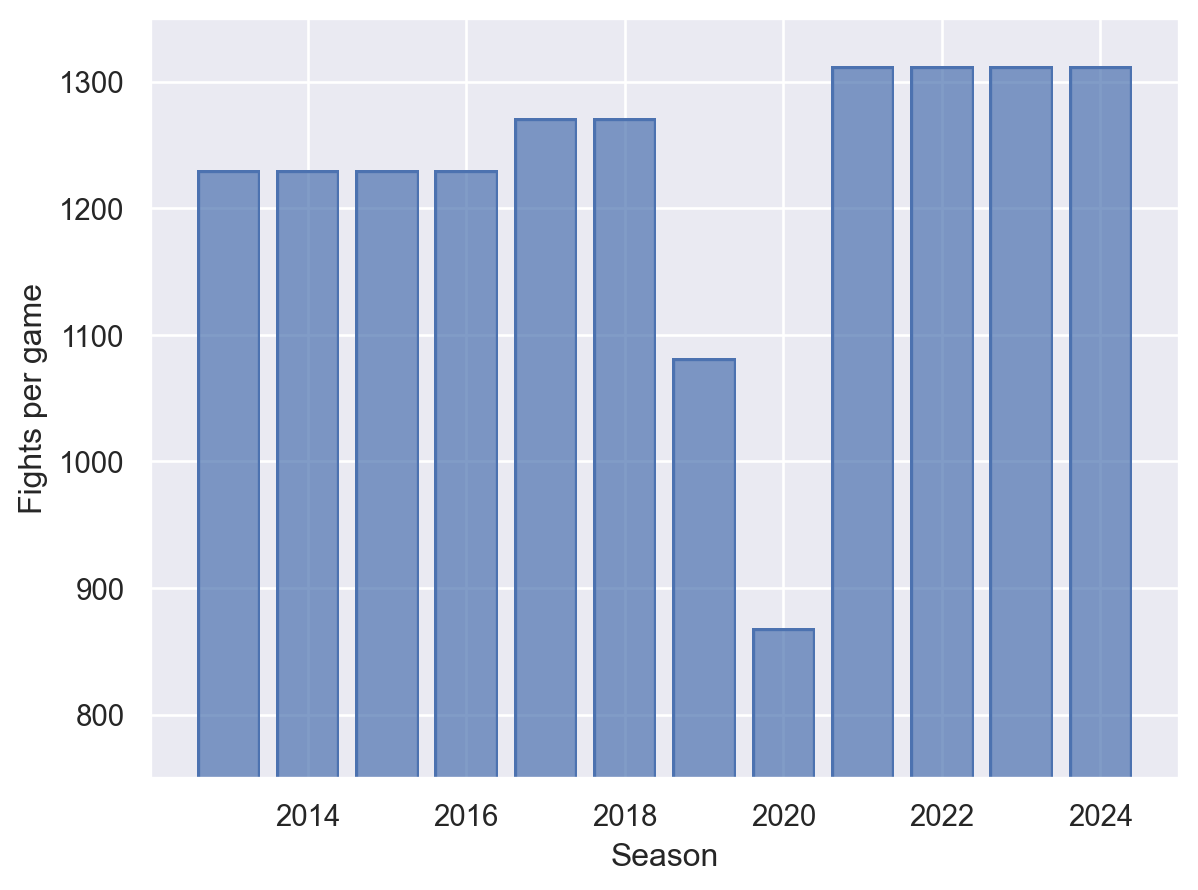

In [19]:
(
    so.Plot(season_df, x="season_start", y="game_ct")
    .add(so.Bar())
    .label(x="Season", y="Fights per game")
    .limit(y=(750, 1350))
)

We now visualize the number of fights per game over time.

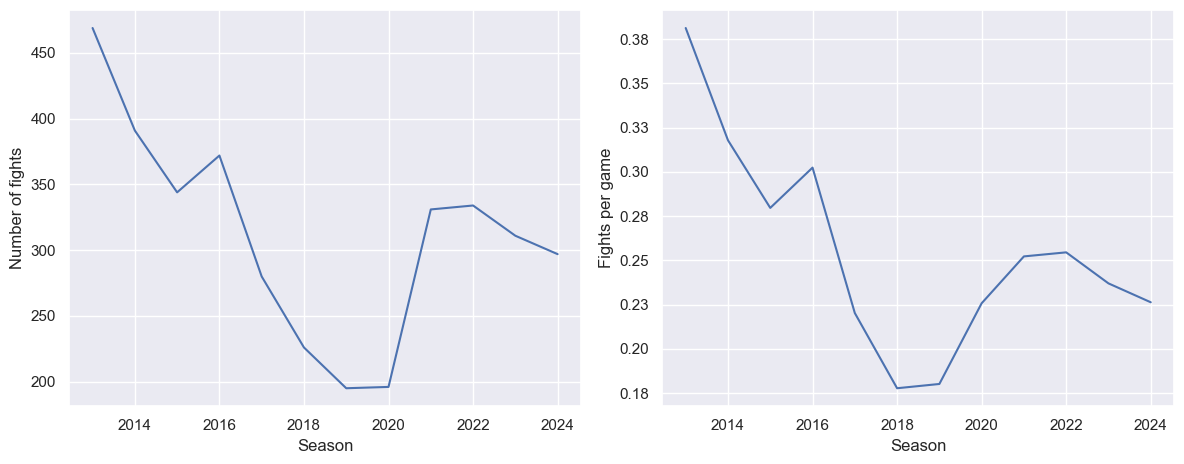

In [20]:
fig, (ct_ax, rate_ax) = plt.subplots(ncols=2, sharex=True, figsize=SIDE_BY_SIDE_FIGSIZE)

fight_ct_plot.on(ct_ax).plot()

(
    so.Plot(
        season_df.with_columns(fights_per_game=pl.col("fight_ct") / pl.col("game_ct")),
        x="season_start",
        y="fights_per_game",
    )
    .add(so.Line())
    .scale(y=so.Continuous().label(like="{x:.2f}"))
    .label(x="Season", y="Fights per game")
    .on(rate_ax)
    .plot()
)

fig.tight_layout();

In fact, we see the same trend in the number of fights per game of fights per game as in the absolute number of fights.  The [consensus explanation](https://www.espn.com/nhl/story/_/id/27283018/the-new-normal-why-fighting-nhl-dropped-historic-lows) for this drop is that increasing competitiveness of the league has caused team to prioritize low cost skill players over enforcers in their fourth lines:

> Today, the fourth-liners are cost-efficient skill players instead of goons, and staged fights are a rarity without those pugilists on the rosters.

### Number of votes per fight

We now examine the number of votes each fight has accumulated.

In [21]:
VOTE_COLS = ["away_votes", "draw_votes", "home_votes"]

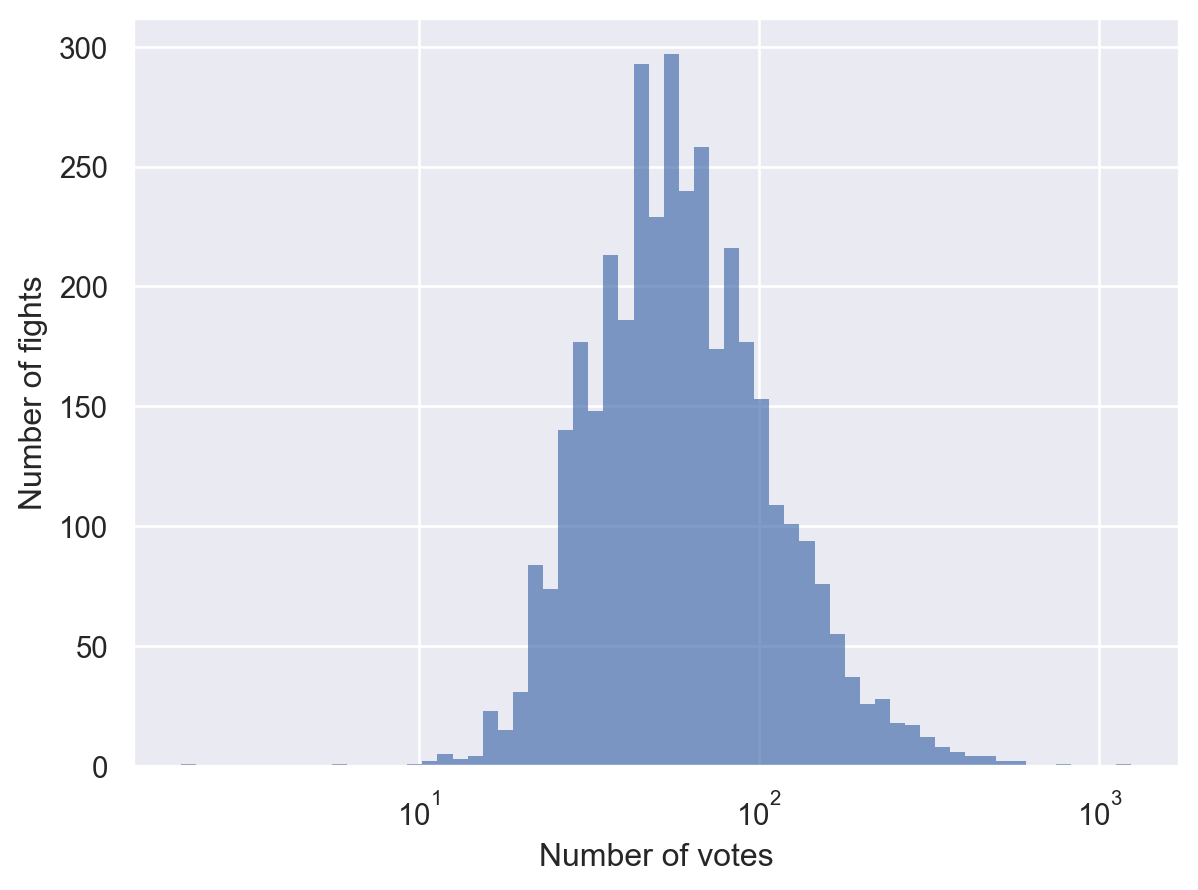

In [22]:
(
    so.Plot(df[VOTE_COLS].sum_horizontal())
    .add(so.Bars(edgewidth=0), so.Hist())
    .label(x="Number of votes", y="Number of fights")
    .scale(x="log")
)

We see that the number of votes roughly follows a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), with most fights receiving between ten and one hundred votes, and a smaller but appreciable number of fights receiving between one hundred and on thousand votes.  Rather than set a minimum number of votes for a fight to be included or similar, we will choose a model that appropriately weights the conclusions it draws from a fight according to the number of votes that fight received, along with their distribution between the each of the outcomes.

### Fight outcomes

We now turn our attention to the outcome of each fight, as voted on by vistiors to hockeyfights.com.  As the screenshot in the introduction shows, the options are to vote that the home player won the fight, that the fight was a draw, or that the away player won the fight.

In [23]:
df = df.with_columns(
    outcome=pl.concat_list(VOTE_COLS)
    .list.arg_max()
    .replace_strict({i: col for i, col in enumerate(VOTE_COLS)})
    .str.split("_")
    .list.first()
)

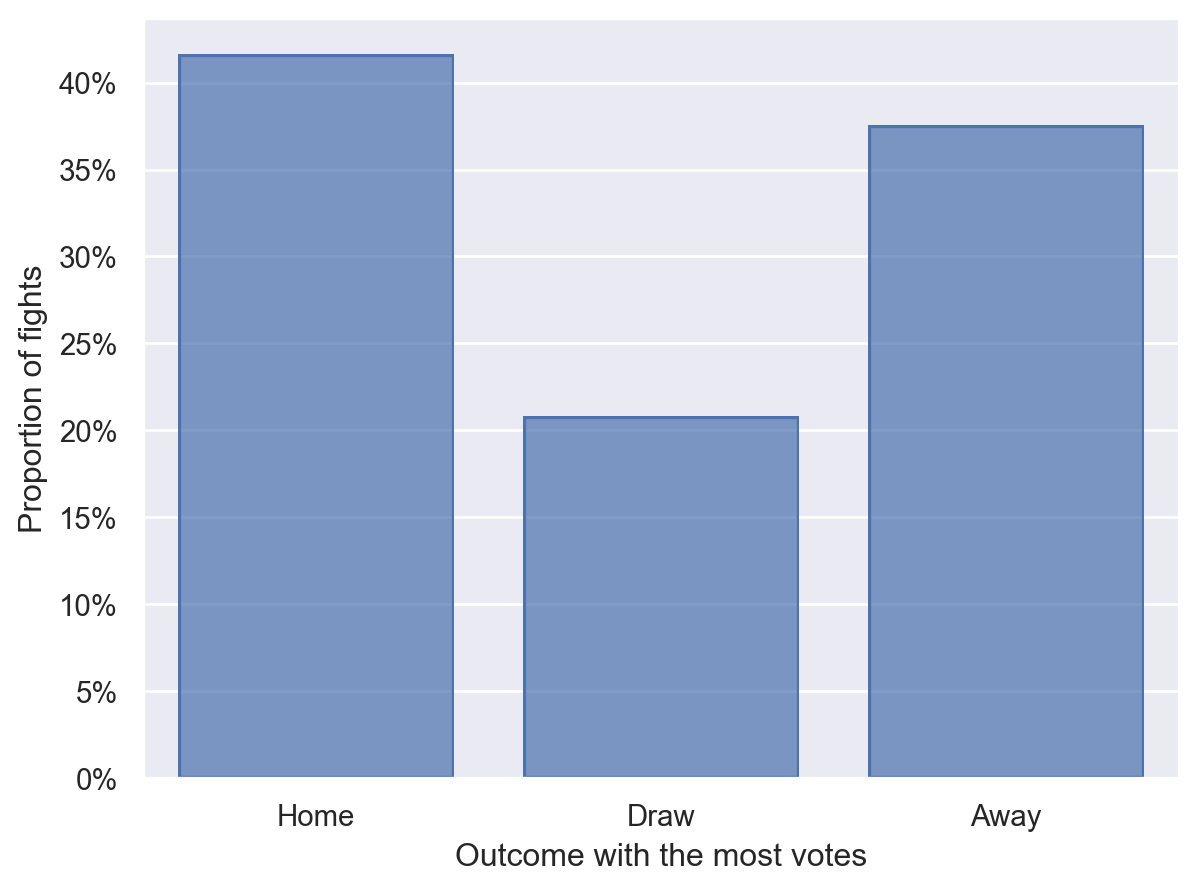

In [24]:
(
    so.Plot(df["outcome"].str.to_titlecase())
    .add(so.Bar(), so.Hist(stat="density"))
    .scale(y=so.Continuous().label(pct_formatter()))
    .label(x="Outcome with the most votes", y="Proportion of fights")
)

We see that roughly 20% of fights are voted draws, with the home player winning slightly over 40% of fights, and the away player winning slightly under 40% of them.  Capturing this slight home-ice advantage in fighting will be the first empirical test of our models.

We now plot outcome share over time.

In [25]:
season_outcome_df = (
    df.with_columns(
        pl.col("outcome").str.to_titlecase(),
        pl.len().over("season_start").alias("fight_ct"),
    )
    .group_by(["season_start", "outcome"])
    .agg(pl.col("fight_ct").first(), outcome_ct=pl.len())
    .with_columns(fight_pct=pl.col("outcome_ct") / pl.col("fight_ct"))
)

In [26]:
season_outcome_plot = (
    so.Plot(season_outcome_df, x="season_start", y="fight_pct", color="outcome")
    .add(so.Line())
    .scale(y=so.Continuous().label(pct_formatter()))
    .label(x="Season", y="Proportion of fights", color=str.capitalize)
)

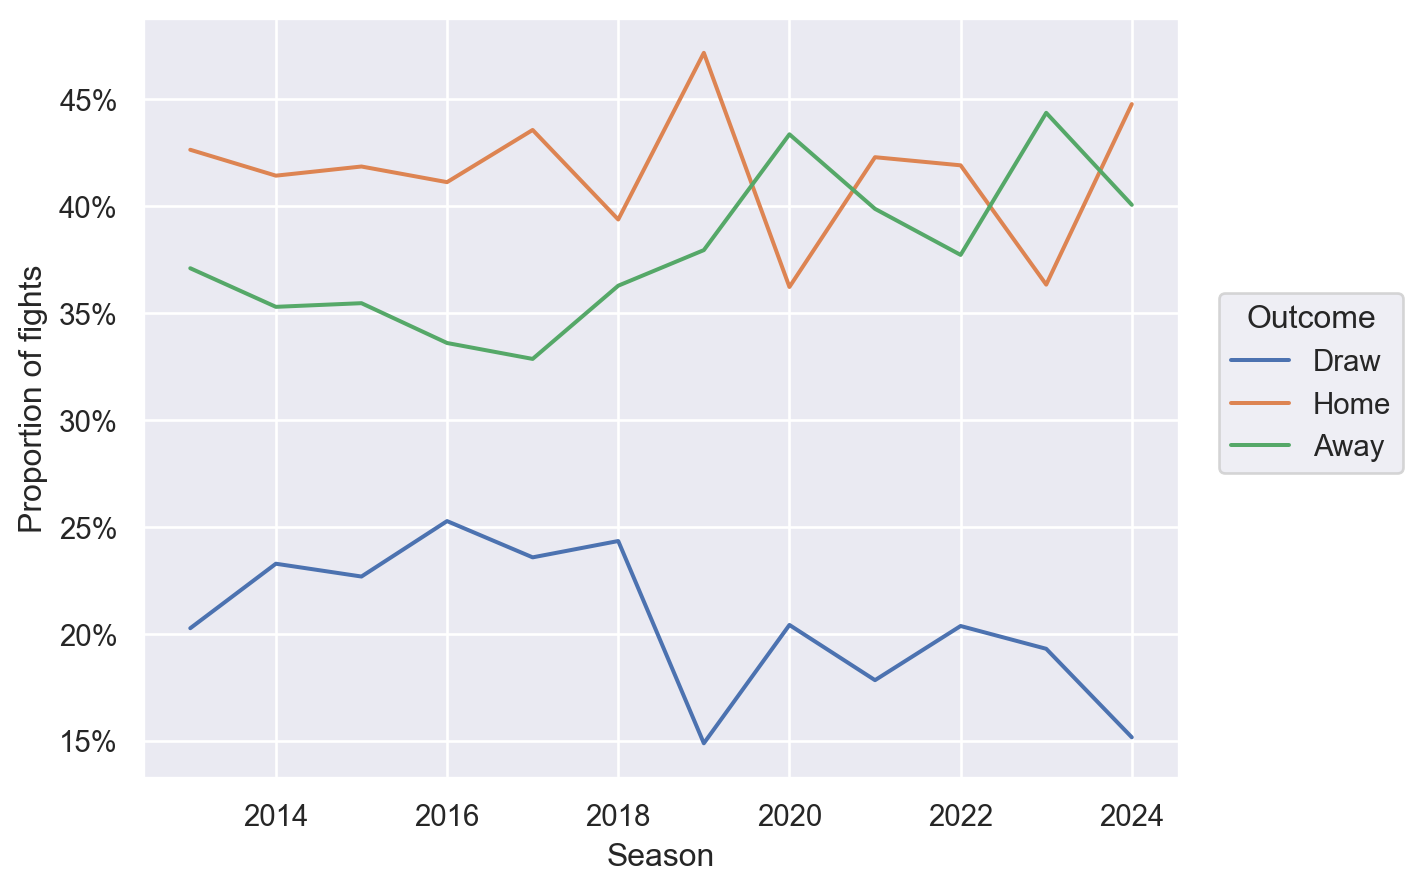

In [27]:
season_outcome_plot

Interestingly, home ice advantage seems to have lessened over time starting in 2017, and it essentially disappeared after 2019. I find it plausible that home ice advantage would have narrowed or disappeared during the COVID-impacted seasons of 2019-2020 and 2020-2021, but the fact that a consistent home ice advantage has not returned since then is a bit curious.  We will use our models to explore this question more deeply.

## Modeling

We now begin modelling the votes received by each fight, starting with very simple but illustrative models and gradually increasing model complexity.

### No home-ice advantage

To introduce some of the basic building blocks of our Bayesian IRT model of fight outcomes, we begin with an overly simple model that does not include the possibility of home-ice advantage.

Throughout this post, $i$ will index of the fight in question in the data. Let

$$\mathbf{n}_i = (n_i^{\text{away}}, n_i^{\text{draw}}, n_i^{\text{home}})$$

be the number of votes cast for each respective outcome for the $i$-th fight, and

$$N_i = n_i^{\text{away}} + n_i^{\text{draw}} + n_i^{\text{home}}$$

be the total number of votes cast for the $i$-th fight.

We now calculate these quantities.

In [28]:
votes_ct = df[VOTE_COLS].to_numpy()
total_votes = votes_ct.sum(axis=1)

We use a [multinomial](https://en.wikipedia.org/wiki/Multinomial_distribution) [ordered logit](https://en.wikipedia.org/wiki/Ordered_logit) likelihood for the number for $\mathbf{n}_i$, which requires us to specify two cutpoints between the three outcomes.  To encode zero home-ice advantage in this model, we specify the cut points as

$$
\begin{align}
    c_{\text{draw}, \text{home}}
        & \sim \text{Half-}N(2.5^2) \\
    c_{\text{away}, \text{draw}}
        & = -c_{\text{draw}, \text{home}}.
\end{align}
$$

It is the symmetry of these cutpoints that eliminates home-ice advantage in the model.

In [29]:
OUTCOMES = ["Away", "Draw", "Home"]

coords = {"cut": ["away_draw", "draw_home"], "Outcome": OUTCOMES}

In [30]:
# the scale necessary to make a halfnormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

In [31]:
with pm.Model(coords=coords) as no_home_model:
    c_draw_home = pm.HalfNormal("c_draw_home", 2.5 * HALFNORMAL_SCALE)
    c = pm.Deterministic("c", np.array([-1, 1]) * c_draw_home, dims="cut")

For this model we define $\eta \equiv 0$, which is somewhat odd, but will change when we start building more complex models.

In [32]:
η = 0

In [33]:
with no_home_model:
    pm.OrderedMultinomial("votes", η, c, total_votes, observed=votes_ct)

When we build more complex IRT models, $\eta$ will be the component through which team, player, and some season effects are expressed.

We now sample from this model's posterior.

In [34]:
SEED = 123456789

In [35]:
def assign_dim(idata, *, var_name, target_idx, dim, coords, group):
    if isinstance(var_name, list):
        for var_name_ in var_name:
            target_dim = idata[group][var_name_].dims[target_idx]

            idata[group][var_name_] = (
                idata[group][var_name_]
                .rename({target_dim: dim})
                .assign_coords(**{dim: coords})
            )

        return idata
    else:
        return assign_dim(
            idata,
            var_name=[var_name],
            target_idx=target_idx,
            dim=dim,
            coords=coords,
            group=group,
        )


def assign_outcome_dim(idata, *, var_name, group):
    return assign_dim(
        idata,
        var_name=var_name,
        target_idx=-1,
        dim="Outcome",
        coords=OUTCOMES,
        group=group,
    )


def compute_log_likelihood(trace, model):
    # we have to work around the fact that pymc can't currently calculate
    # log likelihoods when rvs have explicit initial values
    rvs_to_initvals = model.rvs_to_initial_values
    model.rvs_to_initial_values = {}

    pm.compute_log_likelihood(trace, model=model, progressbar=False)

    model.rvs_to_initial_values = rvs_to_initvals


def sample(model, seed=SEED, cores=8, **sample_kwargs):
    trace = nutpie.sample(
        nutpie.compile_pymc_model(model),
        seed=seed,
        chains=cores,
        cores=cores,
        **sample_kwargs
    )
    trace = assign_outcome_dim(trace, var_name="votes_probs", group="posterior")

    compute_log_likelihood(trace, model)

    return trace

In [36]:
no_home_trace = sample(no_home_model)

The [Gelman-Rubin statistic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic) ($\hat{R}$) statistic shows no cause for concern.

In [37]:
az.rhat(no_home_trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.00193099)

We now compare the posterior probability of each outcome to the observed frequency, and see that this model does not capture home-ice advantage, as intended.

In [38]:
outcome_pct = df["outcome"].value_counts(normalize=True).sort("outcome")

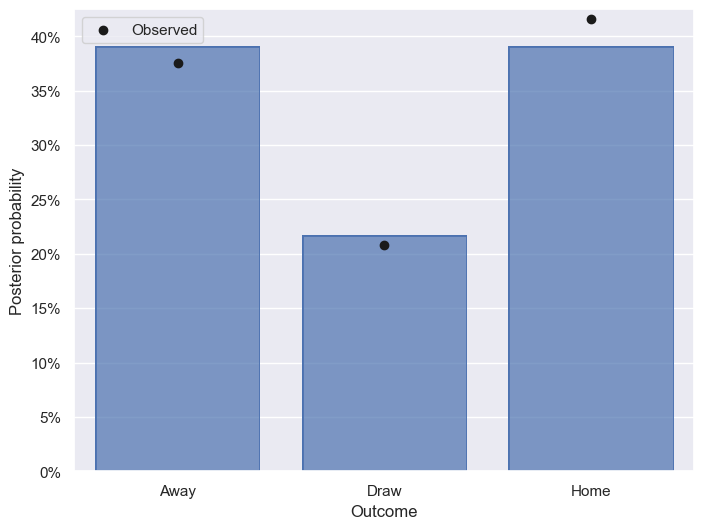

In [39]:
fig, ax = plt.subplots()

ax.scatter(np.arange(3), outcome_pct["proportion"], c="k", zorder=5, label="Observed")

ax.set_ylim(0, 0.425)

ax.legend(loc="upper left")

(
    so.Plot(
        no_home_trace.posterior["votes_probs"].to_dataframe(),
        x="Outcome",
        y="votes_probs",
    )
    .add(so.Bar(), so.Agg())
    .scale(y=so.Continuous().label(pct_formatter()))
    .label(y="Posterior probability")
    .on(ax)
    .show()
)

It therefore overestimates the probability of an away win and underestimates the probability of a home win.

Below we plot the relationship between $c_{\text{draw}, \text{home}}$ and $c_{\text{away}, \text{draw}}$ as a further illustration of the reason there is no home-ice advantage in this model.

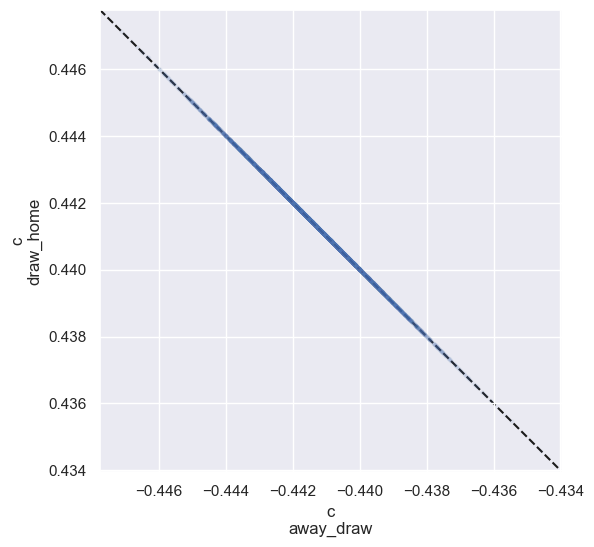

In [40]:
ax = az.plot_pair(no_home_trace, var_names="c", scatter_kwargs={"alpha": 0.05})

ax.axline(
    (
        -no_home_trace.posterior["c_draw_home"].mean(),
        no_home_trace.posterior["c_draw_home"].mean(),
    ),
    slope=-1,
    c="k",
    ls="--",
    zorder=-1,
)

ax.set_aspect("equal");

### Home-ice advantage

We now refine the prior model to incorporate home-ice advantage.  This model still uses the multinomial ordered logistic likelihood with $\eta \equiv 0$, but allows the cut points to vary more independently with the prior

$$c_{\text{draw}, \text{home}}, c_{\text{away}, \text{draw}} \sim N(0, 2.5^2),$$

subject to the constraint $c_{\text{draw}, \text{home}} < c_{\text{away}, \text{draw}}$.

In [41]:
with pm.Model(coords=coords) as home_model:
    c = pm.Normal(
        "c",
        0,
        2.5,
        dims="cut",
        transform=pm.distributions.transforms.ordered,
        initval=np.array([-1, 1]),
    )

We now define the likelihood and sample from the model.

In [42]:
η = 0

with home_model:
    pm.OrderedMultinomial("votes", η, c, total_votes, observed=votes_ct)

In [43]:
home_trace = sample(home_model)

Again, the [Gelman-Rubin statistic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic) ($\hat{R}$) statistic shows no cause for concern.

In [44]:
az.rhat(home_trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.0016775)

Again we compare the posterior probability of each outcome to the observed frequency.

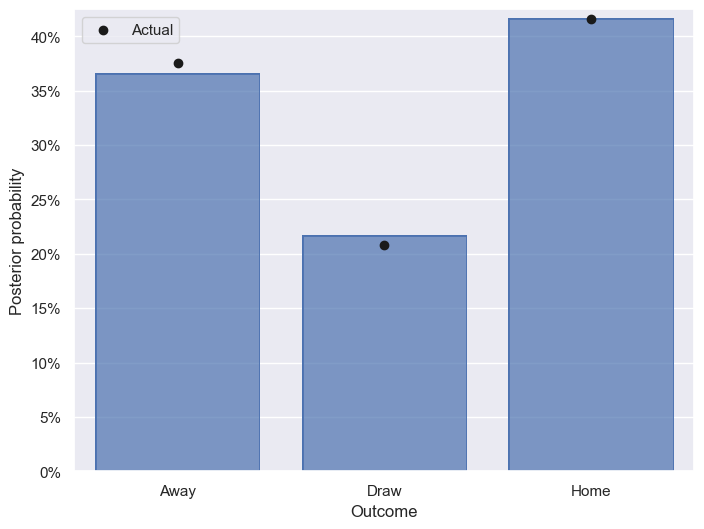

In [45]:
fig, ax = plt.subplots()

ax.scatter(np.arange(3), outcome_pct["proportion"], c="k", zorder=5, label="Actual")

ax.set_ylim(0, 0.425)

ax.legend(loc="upper left")

(
    so.Plot(
        home_trace.posterior["votes_probs"].to_dataframe(),
        x="Outcome",
        y="votes_probs",
    )
    .add(so.Bar(), so.Agg())
    .scale(y=so.Continuous().label(pct_formatter()))
    .label(y="Posterior probability")
    .on(ax)
    .show()
)

We see that this model captures the probability that the home player is voted winner of the fight fairly well, but underestimates the probability of the away player and overestimates the probability of a draw.

To see why this is, we revisit the plot of these quantities by season, breaking seasons into those up to and including 2019-2020 and those after (and including) 2020-2021.  As we saw above, there is a marked increase in the percentage of victories for away players, coming largely at the expense of fewer draws around this changepoint.

In [46]:
SEASON_SPLIT = 2019

In [47]:
split_outcome_df = (
    df.with_columns(season_before=pl.col("season_start") <= SEASON_SPLIT)
    .with_columns(before_ct=pl.len().over("season_before"))
    .group_by(("season_before", "outcome"))
    .agg(proportion=pl.len() / pl.col("before_ct").first())
    .sort(("season_before", "outcome"))
)

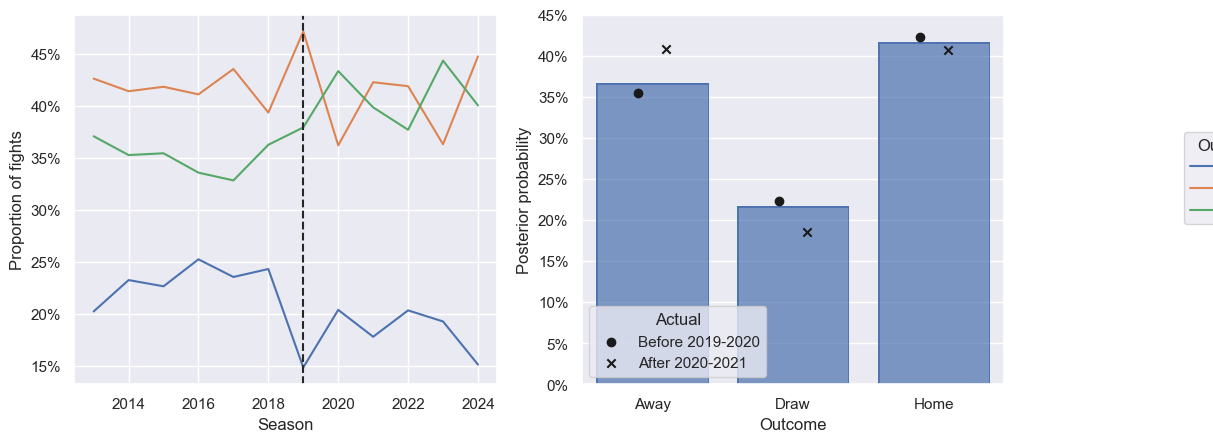

In [48]:
fig, (season_ax, split_ax) = plt.subplots(ncols=2, figsize=SIDE_BY_SIDE_FIGSIZE)

season_outcome_plot.on(season_ax).plot()
season_ax.axvline(SEASON_SPLIT, c="k", ls="--")

split_ax.scatter(
    np.arange(3) - 0.1,
    split_outcome_df.filter(pl.col("season_before"))["proportion"],
    c="k",
    zorder=5,
    label=f"Before {SEASON_SPLIT}-{SEASON_SPLIT + 1}",
)
split_ax.scatter(
    np.arange(3) + 0.1,
    split_outcome_df.filter(~pl.col("season_before"))["proportion"],
    c="k",
    marker="x",
    zorder=5,
    label=f"After {SEASON_SPLIT + 1}-{SEASON_SPLIT + 2}",
)

split_ax.set_ylim(0, 0.45)

split_ax.legend(title="Actual", loc="lower left")

(
    so.Plot(
        home_trace.posterior["votes_probs"].to_dataframe(),
        x="Outcome",
        y="votes_probs",
    )
    .add(so.Bar(), so.Agg())
    .scale(y=so.Continuous().label(pct_formatter()))
    .label(y="Posterior probability")
    .on(split_ax)
    .show()
)

fig.tight_layout();

We see that the posterior outcome probabilities more closely match the actual outcome proportions from the seasons through 2019-2020 than those after (and including) 2020-2021.

Below we visualize the proportion of fights happening through each season (including all seasons before it).

In [49]:
season_cum_pct = (
    df["season_start"]
    .value_counts()
    .sort("season_start")
    .with_columns(cum_pct=pl.col("count").cum_sum() / pl.col("count").sum())
)

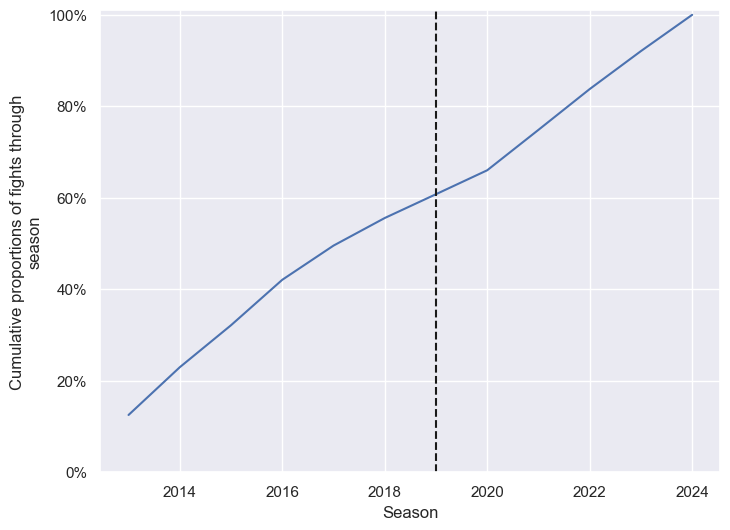

In [50]:
fig, ax = plt.subplots()

ax.plot(season_cum_pct["season_start"], season_cum_pct["cum_pct"])
ax.axvline(SEASON_SPLIT, c="k", ls="--")

ax.set_xlabel("Season")

ax.yaxis.set_major_formatter(pct_formatter())
ax.set_ylim(0, 1.01)
ax.set_ylabel(wrap("Cumulative proportions of fights through season"));

We see that about 60% of fights happened before the 2019-2020 season, so it makes sense that the posterior probabilities more closely align with this period with more data.

We now visualize the relationship between the cut points; contrasting this plot with that from the prior model is illustrative.

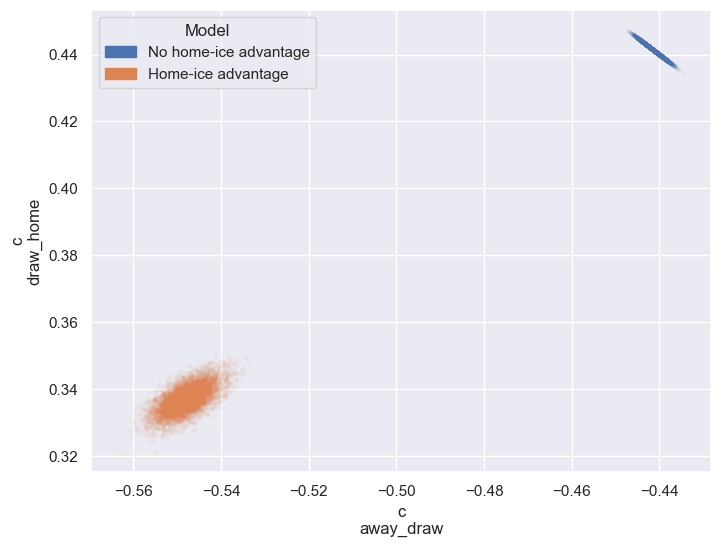

In [51]:
fig, ax = plt.subplots()

az.plot_pair(no_home_trace, var_names="c", scatter_kwargs={"alpha": 0.05}, ax=ax)
az.plot_pair(home_trace, var_names="c", scatter_kwargs={"alpha": 0.05}, ax=ax)

ax.legend(
    handles=[
        patches.Patch(color="C0", label="No home-ice advantage"),
        patches.Patch(color="C1", label="Home-ice advantage"),
    ],
    title="Model",
);

#### Model comparison

We now compare these two models based on their [expected log pointwise predictive density](https://academic.oup.com/jrsssb/article-abstract/64/4/583/7098621?redirectedFrom=fulltext) (ELPD).

In [52]:
traces = {"No Home": no_home_trace, "Home": home_trace}

In [53]:
comp_df = az.compare(traces)

In [54]:
comp_df.loc[:, :"dse"]

rank       elpd_loo      p_loo   elpd_diff    weight           se  \
Home        0 -116638.459291  71.367693    0.000000  0.523194  1732.718135   
No Home     1 -117051.931167  18.674791  413.471876  0.476806  1749.585706   

                dse  
Home       0.000000  
No Home  218.687853

We see that the model that includes home-ice advantage is slightly better by this measure.

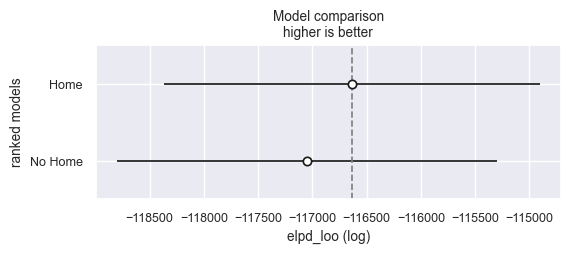

In [55]:
az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False, textsize=9);

### Season-varying home-ice advantage

We now build a model that will capture the changing nature of home-ice advantage better.  We use hierarchical normal cut points that vary by season

$$
\begin{align}
    \mu_{c_{\text{draw}, \text{home}}}, \mu_{c_{\text{away}, \text{draw}}}
        & \sim N(0, 2.5^2) \\
    \sigma_c^2
        & \sim \text{Half-}N(2.5^2) \\
    c_{\text{away}, \text{draw}, j}
        & \sim N(\mu_{c_{\text{away}, \text{draw}}}, \sigma_c^2) \\
    c_{\text{draw}, \text{home}, j}
        & \sim N(\mu_{c_{\text{draw}, \text{home}}}, \sigma_c^2)
\end{align}
$$

subject to the constraint $\mu_{c_{\text{draw}, \text{home}}} < \mu_{c_{\text{away}, \text{draw}}}$.  Throughout the rest of this post, $j$ will be the index of the season the fight in question occurred during, and $j(i)$ will be the index of the season associated with the $i$-th fight.

In [56]:
season = df["season_start"].to_numpy() - seasons.min()

In [57]:
coords["season"] = seasons

For sampling efficiency, we use a mathematical equivalent [noncentered parameterization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/) of these hierarchical normal priors.

In [58]:
def noncentered_normal(name, *, μ=0, dims):
    Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)

    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

In [59]:
with pm.Model(coords=coords) as season_home_model:
    μ_c = pm.Normal(
        "μ_c",
        0,
        2.5,
        dims="cut",
        transform=pm.distributions.transforms.ordered,
        initval=np.array([-1, 1]),
    )
    c = noncentered_normal("c", μ=μ_c, dims=("season", "cut"))

We define a few data containers that will help facilitate posterior predictive sampling.

In [60]:
with season_home_model:
    season_ = pm.Data("season", season)

    total_votes_ = pm.Data("total_votes", total_votes)
    votes_ct_ = pm.Data("votes_ct", votes_ct)

The likelihood for this model remains similar to the previous two, although the cutpoints vary based on the season the fight occurred during.  This model will be the final one with $\eta \equiv 0$.

In [61]:
η = 0

with season_home_model:
    pm.OrderedMultinomial("votes", η, c[season_], total_votes_, observed=votes_ct_)

We now sample from the model's posterior distribution.

In [62]:
season_home_trace = sample(season_home_model)

Again, the [Gelman-Rubin statistic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic) ($\hat{R}$) statistic shows no cause for concern.

In [63]:
az.rhat(season_home_trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.00722552)

Again we compare the posterior probability of each outcome to the observed frequency.

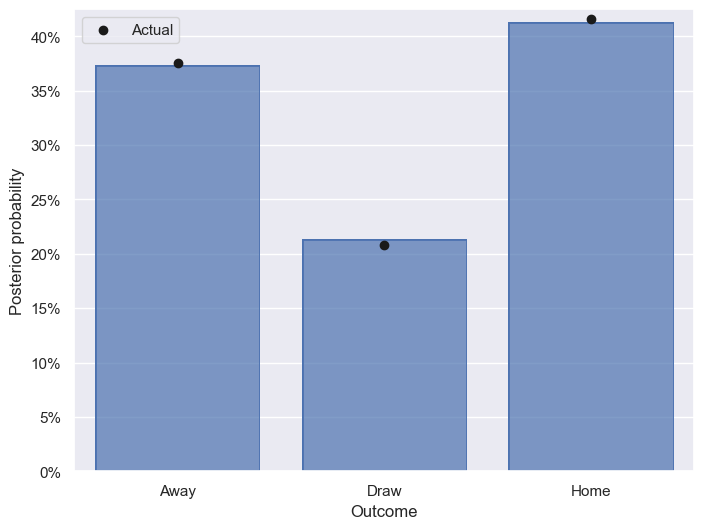

In [64]:
fig, ax = plt.subplots()

ax.scatter(np.arange(3), outcome_pct["proportion"], c="k", zorder=5, label="Actual")

ax.set_ylim(0, 0.425)

ax.legend(loc="upper left")

(
    so.Plot(
        season_home_trace.posterior["votes_probs"]
        .mean(dim=("chain", "draw"))
        .to_dataframe(),
        x="Outcome",
        y="votes_probs",
    )
    .add(so.Bar(), so.Agg())
    .scale(y=so.Continuous().label(pct_formatter()))
    .label(y="Posterior probability")
    .on(ax)
    .show()
)

We see that this model's posterior probability of each outcome aligns much more closely (though not perfectly) with the observed frequencies.

To better explore the per-season home-ice advantages inferred by the model, we use the data containers to sample from the posterior predictive distribution of the outcome probabilities for each season.

In [65]:
PP_TOTAL_VOTES = 100_000

pp_seasons = seasons - seasons.min()

pp_total_votes = np.full_like(pp_seasons, PP_TOTAL_VOTES)
pp_votes_ct = np.ones((pp_seasons.size, len(OUTCOMES)), dtype=np.int32)

In [66]:
def sample_posterior_predictive(trace, *, dim, coords, group="posterior_predictive"):
    pp_trace = pm.sample_posterior_predictive(
        trace, random_seed=SEED, progressbar=False
    )

    pp_trace = assign_outcome_dim(
        pp_trace, var_name="votes", group="posterior_predictive"
    )
    pp_trace["posterior_predictive"] = pp_trace.posterior_predictive.assign(
        votes_probs=pp_trace.posterior_predictive["votes"]
        / pp_trace.posterior_predictive["votes"].sum(dim="Outcome")
    )
    pp_trace = assign_outcome_dim(
        pp_trace, var_name="votes_probs", group="posterior_predictive"
    )
    pp_trace = assign_dim(
        pp_trace,
        var_name=["votes", "votes_probs"],
        target_idx=-2,
        dim=dim,
        coords=coords,
        group="posterior_predictive",
    )

    trace[group] = pp_trace.posterior_predictive.copy()

    return trace

In [67]:
with season_home_model:
    pm.set_data(
        {"season": pp_seasons, "total_votes": pp_total_votes, "votes_ct": pp_votes_ct}
    )

    season_home_trace = sample_posterior_predictive(
        season_home_trace, dim="season", coords=coords["season"], group="predictive"
    )

Sampling: [votes]


We see that the posterior predictive probabilities do a reasonably good job of capturing the observed frequency of each outcome on a per-season basis.

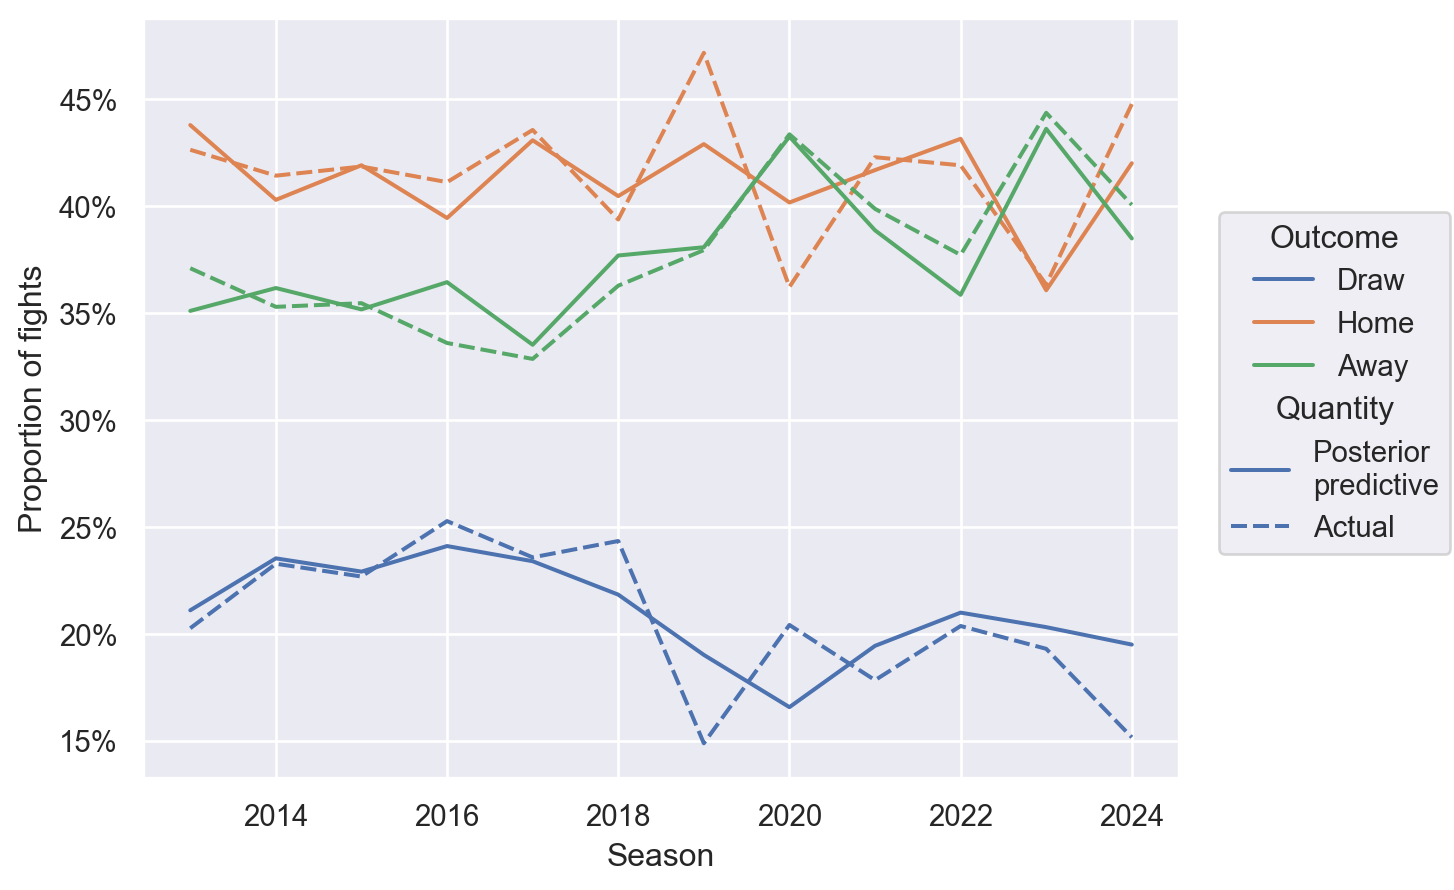

In [68]:
(
    so.Plot(
        (
            season_home_trace.predictive["votes_probs"]
            .mean(dim=("chain", "draw"))
            .to_dataframe()
            .reset_index()
            .pipe(pl.from_pandas)
            .join(
                season_outcome_df.rename(
                    {"season_start": "season", "outcome": "Outcome"}
                ).select("season", "Outcome", "fight_pct"),
                on=("season", "Outcome"),
            )
            .rename({"votes_probs": "Posterior\npredictive", "fight_pct": "Actual"})
            .unpivot(
                index=["season", "Outcome"], variable_name="Quantity", value_name="pct"
            )
        ),
        x="season",
        y="pct",
        color="Outcome",
        linestyle="Quantity",
    )
    .add(so.Line())
    .scale(y=so.Continuous().label(pct_formatter()))
    .label(x="Season", y="Proportion of fights")
)

Subtracting the posterior predictive probability of the away player winning from that of the home player winning, we produce a by-season plot of the home-ice advantage.

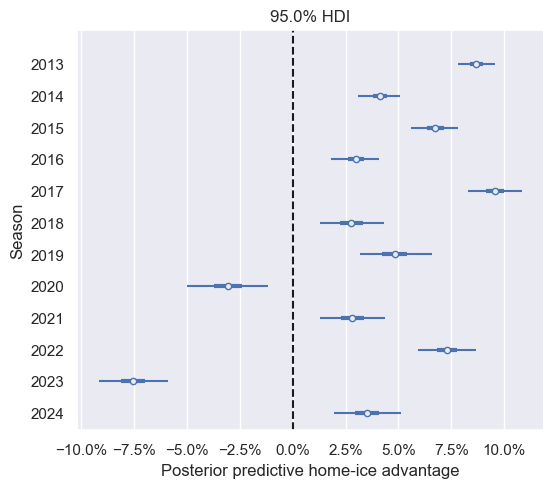

In [69]:
(ax,) = az.plot_forest(
    season_home_trace.predictive["votes_probs"]
    .sel({"Outcome": ["Away", "Home"]})
    .diff(dim="Outcome"),
    combined=True,
    hdi_prob=0.95,
    labeller=az.labels.NoVarLabeller(),
)

ax.axvline(0, c="k", ls="--")

ax.xaxis.set_major_formatter(pct_formatter(1))
ax.set_xlabel("Posterior predictive home-ice advantage")

ax.set_ylabel("Season");

This plot confirms that home-ice advantage has indeed been getting smaller over time and was in fact a disadvantage for the 2020-2021 and 2023-2024 seasons.

#### Model comparison

We again compare the three models based on their ELPD.

In [70]:
traces["Season/home"] = season_home_trace

In [71]:
comp_df = az.compare(traces)

In [72]:
comp_df.loc[:, :"dse"]

rank       elpd_loo       p_loo   elpd_diff    weight  \
Season/home     0 -116386.899798  699.909390    0.000000  0.436403   
Home            1 -116638.459291   71.367693  251.559493  0.184791   
No Home         2 -117051.931167   18.674791  665.031370  0.378806   

                      se         dse  
Season/home  1745.596783    0.000000  
Home         1732.718135  179.537387  
No Home      1749.585706  310.904439

We see that the model that includes per-season home-ice advantage is slightly better by this measure.

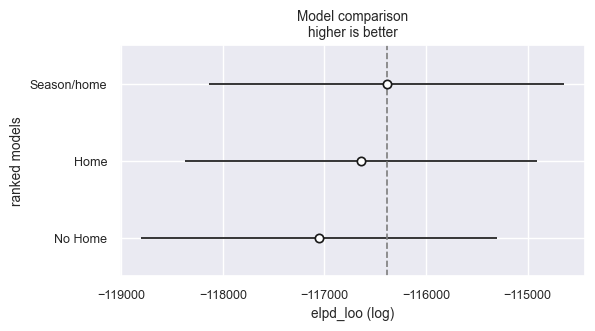

In [73]:
az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False, textsize=9);

### Team IRT

Now that we have a model that captures the time-varying nature of home-ice advantage, we will extend it to include team-level fighting "skill."

(Here "skill" is in quotes because we will decide towards the end of this post if fighting is a truly a "skill" teams possess and is correlated season-over-season.  For simplicity sake we will usually drop the quotes from now on.)

First we do a bit of feature engineering to turn the team names into indices.

In [74]:
away_team = df["away_team"].to_physical().to_numpy().astype(np.int32)
home_team = df["home_team"].to_physical().to_numpy().astype(np.int32)

We model the fighting skill of each team ($\beta_k$) and the team's home-ice advantage ($\beta_k^{\text{home}}$) as zero-mean hierachical normal distributions

$$
\begin{align}
    \sigma_{\beta}^2, \sigma_{\beta^{\text{home}}}^2
        & \sim \text{Half-}N(2.5^2) \\
    \beta_k
        & \sim N(0, \sigma_{\beta}^2), \\
    \beta_k^{\text{home}}
        & \sim N(0, \sigma_{\beta^{\text{home}}}^2).
\end{align}
$$

Throughout the rest of this post, $k(i)$ will be the index of the home team associated with the $i$-th fight and $\ell(i)$ will be index of the away team associated with the $i$-th fight.

We then let

$$
\begin{align}
    \eta_i^{\text{away}}
        & = \beta_{\ell(i)}, \\
    \eta_i^{\text{home}}
        & = \beta_{k(i)}^{\text{home}} + \beta_{k(i)}, \\
    \eta_i
        & = \eta_i^{\text{home}} - \eta_i^{\text{away}}.
\end{align}
$$

Instead of $\eta \equiv 0$, $\eta_i$ now represents the difference in fighting skill for the home and away team involved in the $i$-th fight.  It is important that the prior distribution for the $\beta_k$s to have mean zero, because if this mean were allowed to vary freely, it would cancel in the definiton of $\eta$, leading to an [unidentified](https://en.wikipedia.org/wiki/Identifiability) model which would cause sampling problems.

First we define data containers that will make posterior predictive sampling easier.

In [75]:
coords["team"] = teams.categories.to_numpy()

In [76]:
def make_switch(rv, *, name=None, alt_val=None):
    if name is None:
        name = rv.name

    if alt_val is None:
        alt_val = pt.zeros_like(rv)

    switch = pm.Data(f"use_{name}", True)

    return pt.switch(switch, rv, alt_val)

In [77]:
with pm.Model(coords=coords) as team_model:
    season_ = pm.Data("season", season)

    away_team_ = pm.Data("away_team", away_team)
    home_team_ = pm.Data("home_team", home_team)

    total_votes_ = pm.Data("total_votes", total_votes)
    votes_ct_ = pm.Data("votes_ct", votes_ct)

Next we define $\beta_k$ and $\eta_i$ as above.

In [78]:
with team_model:
    β = noncentered_normal("β", dims="team")
    β_home = noncentered_normal("β_home", dims="team")

    η_away = make_switch(β, name="away_team")[away_team_]
    η_home = make_switch(β_home + β, name="home_team")[home_team_]

    η = η_home - η_away

The cut points and likelihood are the same as in the previous model, with the exciting exception that we no longer have $\eta \equiv 0$.

In [79]:
with team_model:
    μ_c = pm.Normal(
        "μ_c",
        0,
        2.5,
        dims="cut",
        transform=pm.distributions.transforms.ordered,
        initval=np.array([-1, 1]),
    )
    c = noncentered_normal("c", μ=μ_c, dims=("season", "cut"))
    c_ = make_switch(c[season_], name="season_c", alt_val=μ_c)

    pm.OrderedMultinomial("votes", η, c_, total_votes_, observed=votes_ct_)

We now sample from the model's posterior distribution.

In [80]:
team_trace = sample(team_model)

Again, the [Gelman-Rubin statistic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic) ($\hat{R}$) statistic shows no cause for concern.

In [81]:
az.rhat(team_trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.00513982)

#### Residual analysis

Now that our models capture per-season home-ice advantage reasonably well, we will use binned residuals to evaluate the fit of our models.  For more information on binned residuals, consult [_Regression and Other Stories_](https://users.aalto.fi/~ave/ROS.pdf) §14.5.

In [82]:
def qcut(s, *, bins=50):
    return (
        pd.qcut(s, bins)
        .apply(lambda intvl: intvl.mid)
        .astype(np.float_)
        .pipe(pl.from_pandas)
        .rename("bin")
    )

In [83]:
def binned_resid(bins, actual_pct, post_pct):
    actual_col = pl.col(actual_pct.name)

    return (
        pl.concat(
            (bins.to_frame(), actual_pct.to_frame(), post_pct.to_frame()),
            how="horizontal",
        )
        .group_by(bins.name)
        .agg(pl.all().mean(), pl.len())
        .with_columns(stderr=(actual_col * (1 - actual_col) / pl.col("len")).sqrt())
        .sort(bins.name)
    )

We now plot the binned residuals against the posterior outcome probabilities.

In [84]:
post_pct = {
    "team": (
        team_trace.posterior["votes_probs"]
        .mean(dim=("chain", "draw"))
        .to_dataframe()["votes_probs"]
        .unstack()
        .pipe(pl.from_pandas)
    )
}

In [85]:
votes_pct = df[VOTE_COLS] / df[VOTE_COLS].sum_horizontal()

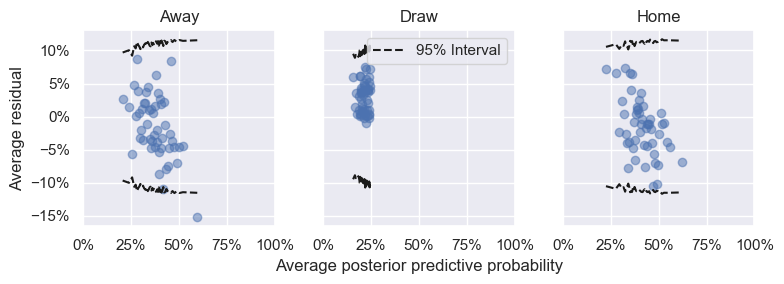

In [86]:
fig, axes = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT)
)

for outcome, ax in zip(OUTCOMES, axes):
    bins = qcut(post_pct["team"][outcome.capitalize()].to_pandas(), bins=50)
    resid_df = binned_resid(
        bins, votes_pct[f"{outcome.lower()}_votes"], post_pct["team"][outcome]
    )

    ax.scatter(
        resid_df["bin"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df["bin"],
        marker="o",
        alpha=0.5,
    )

    handle = ax.plot(
        resid_df["bin"], 2 * resid_df["stderr"], c="k", ls="--", label="95% Interval"
    )
    ax.plot(resid_df["bin"], -2 * resid_df["stderr"], c="k", ls="--")

    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(pct_formatter())
    ax.xaxis.set_major_locator(pct_locator)

    ax.set_title(outcome)

axes[1].set_xlabel("Average posterior predictive probability")

axes[0].yaxis.set_major_formatter(pct_formatter())
axes[0].set_ylabel("Average residual")

axes[1].legend(handles=handle, loc="upper right")

fig.tight_layout()

We see that while most of the binned residuals lie within the 95% intervals, it is clear that this model systematically underestimates the probability of a draw.

We also plot the residuals binned by season.

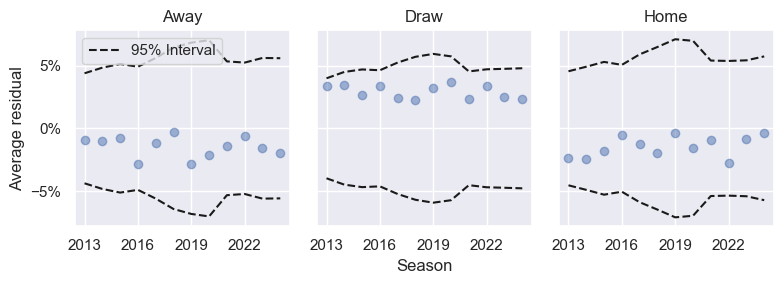

In [87]:
fig, axes = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT)
)

for outcome, ax in zip(OUTCOMES, axes):
    resid_df = binned_resid(
        df["season_start"],
        votes_pct[f"{outcome.lower()}_votes"],
        post_pct["team"][outcome],
    )

    ax.scatter(
        resid_df["season_start"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df[outcome.capitalize()],
        marker="o",
        alpha=0.5,
    )

    handle = ax.plot(
        resid_df["season_start"],
        2 * resid_df["stderr"],
        c="k",
        ls="--",
        label="95% Interval",
    )
    ax.plot(resid_df["season_start"], -2 * resid_df["stderr"], c="k", ls="--")

    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

    ax.set_title(outcome)

axes[1].set_xlabel("Season")

axes[0].yaxis.set_major_formatter(pct_formatter())
axes[0].set_ylabel("Average residual")

axes[0].legend(handles=handle, loc="upper left")

fig.tight_layout()

Here the trend of consistently overestimating the probability of a win by either team's player and underestimating the probability of a draw is even clearer.

#### Model comparison

We again compare the four models based on their ELPD.

In [88]:
traces["Team"] = team_trace

In [89]:
comp_df = az.compare(traces)

In [90]:
comp_df.loc[:, :"dse"]

rank       elpd_loo        p_loo    elpd_diff    weight  \
Team            0 -114219.291260  3571.764768     0.000000  0.477577   
Season/home     1 -116386.899798   699.909390  2167.608538  0.160079   
Home            2 -116638.459291    71.367693  2419.168031  0.120705   
No Home         3 -117051.931167    18.674791  2832.639908  0.241639   

                      se         dse  
Team         1667.424200    0.000000  
Season/home  1745.596783  643.855261  
Home         1732.718135  661.263955  
No Home      1749.585706  716.770969

We see that the model that includes team skill is appreciably better by this measure.

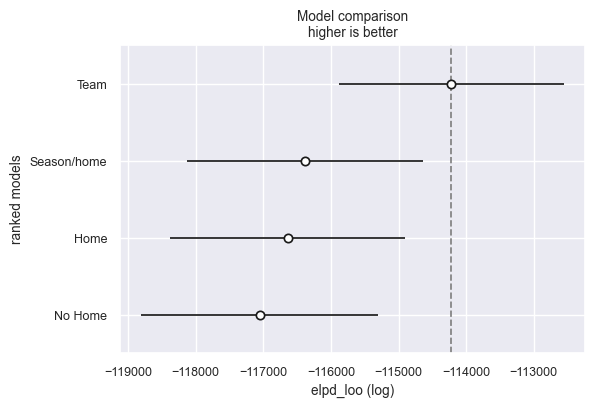

In [91]:
az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False, textsize=9);

#### Interpretation

We now sample from the posterior predictive distribution of this model to interpret it.

First we use the data containers we set up to sample from the posterior predictive distribution for each team at home, against a league-average opponent, in the average season.

In [92]:
n_team = coords["team"].size
pp_team = np.arange(n_team, dtype=np.int32)

pp_season = np.zeros_like(pp_team, dtype=np.int32)

pp_total_votes = np.full_like(pp_team, PP_TOTAL_VOTES, dtype=np.int32)
pp_votes_ct = np.ones((pp_team.size, len(OUTCOMES)), dtype=np.int32)

In [93]:
with team_model:
    pm.set_data(
        {
            "home_team": pp_team,
            "away_team": pp_team,
            "season": pp_season,
            "total_votes": pp_total_votes,
            "votes_ct": pp_votes_ct,
            "use_away_team": False,
            "use_season_c": False,
        }
    )

    team_trace = sample_posterior_predictive(
        team_trace, dim="team", coords=coords["team"], group="home_predictive"
    )

Sampling: [votes]


Next we sample from the posterior predictive distribution for each team when away, against a league-average opponent, in the average season.

In [94]:
with team_model:
    pm.set_data({"use_away_team": True, "use_home_team": False})

    team_trace = sample_posterior_predictive(
        team_trace, dim="team", coords=coords["team"], group="away_predictive"
    )

Sampling: [votes]


Now we visualize the per-team posterior predictive probabilities of winning a fight both at home and away under the above conditions.

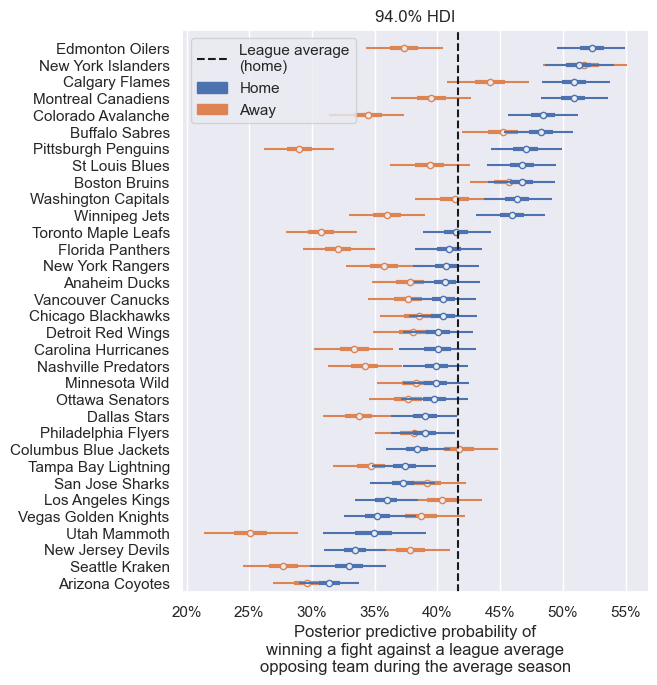

In [95]:
sorted_teams = (
    team_trace.home_predictive["votes_probs"]
    .sel(Outcome="Home")
    .mean(dim=("chain", "draw"))
    .argsort()
)

(ax,) = az.plot_forest(
    team_trace.away_predictive,
    var_names="votes_probs",
    coords={"Outcome": "Away", "team": coords["team"][sorted_teams[::-1]]},
    combined=True,
    labeller=az.labels.NoVarLabeller(),
    colors="C1",
)

az.plot_forest(
    team_trace.home_predictive,
    var_names="votes_probs",
    coords={"Outcome": "Home", "team": coords["team"][sorted_teams[::-1]]},
    combined=True,
    labeller=az.labels.NoVarLabeller(),
    colors="C0",
    ax=ax,
)

ax.axvline(
    team_trace.home_predictive["votes_probs"].sel(Outcome="Home").mean(),
    c="k",
    ls="--",
    label="League average\n(home)",
)

ax.xaxis.set_major_formatter(pct_formatter())
ax.set_xlabel(
    wrap(
        "Posterior predictive probability of winning a fight"
        " against a league average opposing team during the "
        "average season"
    )
)

handles, _ = ax.get_legend_handles_labels()
handles.extend(
    [
        patches.Patch(color="C0", label="Home"),
        patches.Patch(color="C1", label="Away"),
    ]
)

ax.legend(handles=handles, loc="upper left");  # , bbox_to_anchor=(1.025, 0.5));

While this chart is certainly interesting, we will defer interpretation of such charts until we have included all the context we want in our final model.

### Player IRT

Now we extend the Team IRT model to include player skill.  For now, a player's fighting skill will be constant across seasons.

First we do a bit of feature engineering to turn the player's names into indices.

In [96]:
away_player = df["away_player"].to_physical().to_numpy().astype(np.int32)
home_player = df["home_player"].to_physical().to_numpy().astype(np.int32)

We model the fighting skill of each player, $\theta_m$, as a zero-mean hierachical normal distribution

$$
\begin{align}
    \sigma_{\theta}^2
        & \sim \text{Half-}N(2.5^2) \\
    \theta_m
        & \sim N(0, \sigma_{\theta}^2).
\end{align}
$$

Throughout the rest of this post, $m(i)$ will be the index of the home player associated with the $i$-th fight and $o(i)$ will be index of the away team associated with the $i$-th fight.

We then let

$$
\begin{align}
    \eta_i^{\text{away}}
        & = \beta_{\ell(i)} + \theta_{o(i)}, \\
    \eta_i^{\text{home}}
        & = \beta_{k(i)}^{\text{home}} + \beta_{k(i)} + \theta_{m(i)}, \\
    \eta_i
        & = \eta_i^{\text{home}} - \eta_i^{\text{away}}.
\end{align}
$$

As above, it is important that the prior distribution for the $\theta_m$s to have mean zero for the model to be identified.

Again we define data containers that will make posterior predictive sampling easier.

In [97]:
coords["player"] = players.categories.to_list()

In [98]:
with pm.Model(coords=coords) as player_model:
    season_ = pm.Data("season", season)

    away_team_ = pm.Data("away_team", away_team)
    home_team_ = pm.Data("home_team", home_team)

    away_player_ = pm.Data("away_player", away_player)
    home_player_ = pm.Data("home_player", home_player)

    total_votes_ = pm.Data("total_votes", total_votes)
    votes_ct_ = pm.Data("votes_ct", votes_ct)

Next we define $\eta_i$ as above.

In [99]:
with player_model:
    β = noncentered_normal("β", dims="team")
    β_home = noncentered_normal("β_home", dims="team")

    θ = noncentered_normal("θ", dims="player")

    η_away = sum(
        (
            make_switch(β, name="use_away_team")[away_team_],
            make_switch(θ, name="use_away_player")[away_player_],
        )
    )
    η_home = sum(
        (
            make_switch(β_home + β, name="use_home_team")[home_team_],
            make_switch(θ, name="use_home_player")[home_player_],
        )
    )

    η = η_home - η_away

Finally, the cut points and likelihood are defined as in the previous model.

In [100]:
with player_model:
    μ_c = pm.Normal(
        "μ_c",
        0,
        2.5,
        dims="cut",
        transform=pm.distributions.transforms.ordered,
        initval=np.array([-1, 1]),
    )
    c = noncentered_normal("c", μ=μ_c, dims=("season", "cut"))
    c_ = make_switch(c[season_], name="season_c", alt_val=μ_c)

    pm.OrderedMultinomial("votes", η, c_, total_votes_, observed=votes_ct_)

In [101]:
player_trace = sample(player_model, tune=1_000, draws=2_000)

The [Gelman-Rubin statistic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic) ($\hat{R}$) statistic is a bit high, so we proceed with caution.

In [102]:
az.rhat(player_trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.07952008)

#### Residual analysis

We visualize the same binned residuals as before for both the Team and Player IRT models.

In [103]:
post_pct["player"] = (
    player_trace.posterior["votes_probs"]
    .mean(dim=("chain", "draw"))
    .to_dataframe()["votes_probs"]
    .unstack()
    .pipe(pl.from_pandas)
)

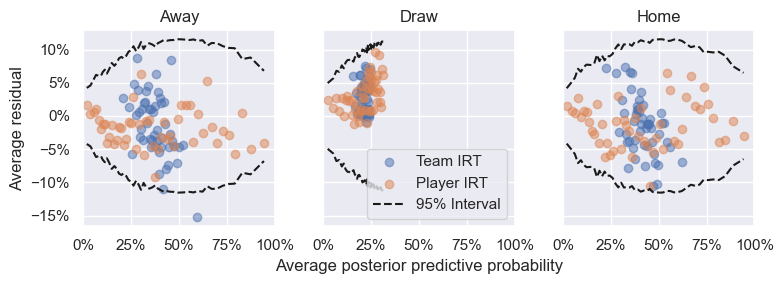

In [104]:
fig, axes = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT)
)

for outcome, ax in zip(OUTCOMES, axes):
    bins = qcut(post_pct["team"][outcome.capitalize()].to_pandas(), bins=50)
    resid_df = binned_resid(
        bins, votes_pct[f"{outcome.lower()}_votes"], post_pct["team"][outcome]
    )

    ax.scatter(
        resid_df["bin"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df["bin"],
        marker="o",
        alpha=0.5,
        c="C0",
        label="Team IRT",
    )

    bins = qcut(post_pct["player"][outcome.capitalize()].to_pandas(), bins=50)
    resid_df = binned_resid(
        bins, votes_pct[f"{outcome.lower()}_votes"], post_pct["player"][outcome]
    )

    ax.scatter(
        resid_df["bin"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df["bin"],
        marker="o",
        alpha=0.5,
        c="C1",
        label="Player IRT",
    )

    ax.plot(
        resid_df["bin"], 2 * resid_df["stderr"], c="k", ls="--", label="95% Interval"
    )
    ax.plot(resid_df["bin"], -2 * resid_df["stderr"], c="k", ls="--")

    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(pct_formatter())
    ax.xaxis.set_major_locator(pct_locator)

    ax.set_title(outcome)

axes[1].set_xlabel("Average posterior predictive probability")

axes[0].yaxis.set_major_formatter(pct_formatter())
axes[0].set_ylabel("Average residual")

axes[1].legend(loc="lower right")

fig.tight_layout()

Again most of the binned residuals lie within the 95% intervals, but this model also systematically underestimates the probability of a draw. However, the Player IRT model significantly increases the range of probabilities that are predicted for either player winning the fight.

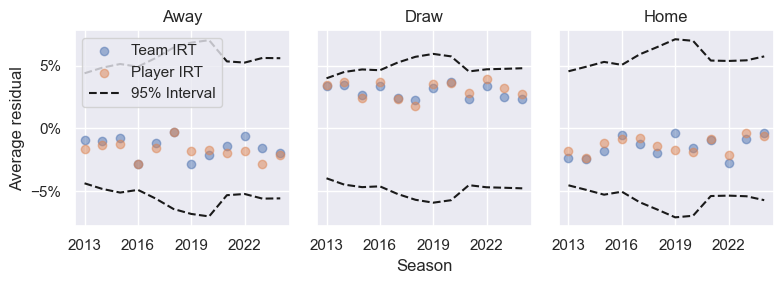

In [105]:
fig, axes = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT)
)

for outcome, ax in zip(OUTCOMES, axes):
    resid_df = binned_resid(
        df["season_start"],
        votes_pct[f"{outcome.lower()}_votes"],
        post_pct["team"][outcome],
    )

    ax.scatter(
        resid_df["season_start"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df[outcome.capitalize()],
        marker="o",
        alpha=0.5,
        c="C0",
        label="Team IRT",
    )

    resid_df = binned_resid(
        df["season_start"],
        votes_pct[f"{outcome.lower()}_votes"],
        post_pct["player"][outcome],
    )

    ax.scatter(
        resid_df["season_start"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df[outcome.capitalize()],
        marker="o",
        alpha=0.5,
        c="C1",
        label="Player IRT",
    )

    ax.plot(
        resid_df["season_start"],
        2 * resid_df["stderr"],
        c="k",
        ls="--",
        label="95% Interval",
    )
    ax.plot(resid_df["season_start"], -2 * resid_df["stderr"], c="k", ls="--")

    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

    ax.set_title(outcome)

axes[1].set_xlabel("Season")

axes[0].yaxis.set_major_formatter(pct_formatter())
axes[0].set_ylabel("Average residual")

axes[0].legend(loc="upper left")

fig.tight_layout()

Here the trend of consistently overestimating the probability of a win by either team's player and underestimating the probability of a draw remains clear.

#### Model comparison

We again compare the five models based on their ELPD.

In [106]:
traces["Player"] = player_trace

In [107]:
comp_df = az.compare(traces)

In [108]:
comp_df.loc[:, :"dse"]

rank       elpd_loo         p_loo     elpd_diff    weight  \
Player          0  -79655.697628  16007.723013      0.000000  0.724038   
Team            1 -114219.291260   3571.764768  34563.593632  0.112220   
Season/home     2 -116386.899798    699.909390  36731.202170  0.044535   
Home            3 -116638.459291     71.367693  36982.761663  0.039830   
No Home         4 -117051.931167     18.674791  37396.233540  0.079377   

                      se          dse  
Player       1412.708937     0.000000  
Team         1667.424200  1550.866832  
Season/home  1745.596783  1676.800085  
Home         1732.718135  1672.053223  
No Home      1749.585706  1691.418028

We see that the model that includes player skill is far surperior to the others by this measure.

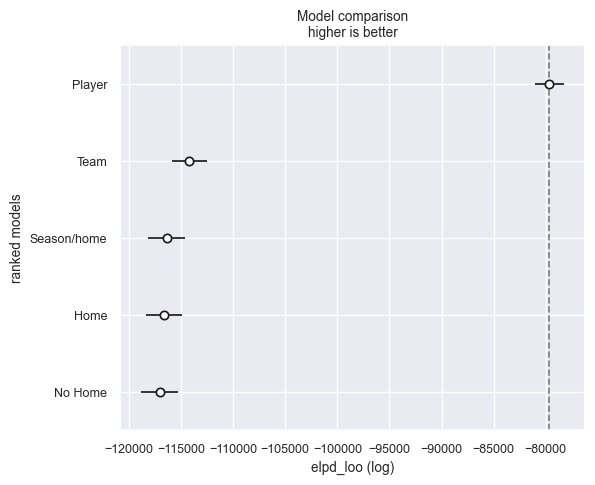

In [109]:
az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False, textsize=9);

Due to the high $\hat{R}$ value, we refrain from interpreting this model and instead move to the final model of this post.

### Full IRT

Finally, we are ready to build a model that allows team and player "skills" to vary by season.  We use the posterior distribution of the inter-season correlation of each of these "skills" to determine if they are truly a skill or just noise.

To do so, we define a multivariate normal prior on each of the skill parameters as follows.  For $\beta_{k, t},$ let

$$\rho_\beta \sim U\left(-\frac{1}{T - 1}, 1\right)$$

be the inter-season correlation of team skill.  Here $t$ is the index of the season in question and $T$ is the total number of seasons.  The lower bound $-\frac{1}{T - 1}$ on the correlation coefficient of a $T$-dimensional exchangeable normal random variable is derived in a previous [post](https://austinrochford.com/posts/exch-param-pymc.html).

We use an exchangeable multivariate normal prior

$$
\begin{align}
    \sigma_{\beta}
        & \sim \text{Half-}N(2.5^2), \\
    \Sigma_{\beta}
        & = \sigma_{\beta}^2 \cdot \begin{pmatrix}
            1 & \rho_{\beta} & \rho_{\beta} & \cdots & \rho_{\beta} \\
            \rho_{\beta} & 1 & \rho_{\beta} & \cdots & \rho_{\beta} \\
             & & \vdots & & \\
             \rho_{\beta} & \rho_{\beta} & \rho_{\beta} & \cdots & 1
        \end{pmatrix}, \\
    \begin{pmatrix}\beta_{k, 1} & \beta_{k, 2} & \cdots & \beta_{k, T}\end{pmatrix}
        & \sim N(0, \Sigma_{\beta}).
\end{align}
$$

The priors on $\beta_k^{\text{home}}$ and $\theta_m$ are defined analogously.

We then let

$$
\begin{align}
    \eta_{i, t}^{\text{away}}
        & = \beta_{\ell(i), t} + \theta_{o(i), t}, \\
    \eta_{i, t}^{\text{home}}
        & = \beta_{k(i), t}^{\text{home}} + \beta_{k(i), t} + \theta_{m(i)}, \\
    \eta_{i, t}
        & = \eta_{i, t}^{\text{home}} - \eta_{i, t}^{\text{away}}.
\end{align}
$$

If we defined the model exactly this way, the sampler would struggle to explore its posterior distribution efficiently.  Instead, we use a mathematically equivalent but more sampler-friendly formulation involving the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\Sigma_{\beta}.$  I have derived a closed-form solution for the Cholesky decomposition of the covariance matrix of an exchangeable normal random variable in a previous [post](https://austinrochford.com/posts/exch-chol-closed.html).

The following functions define the Cholesky decomposition for the covariance matrix of a unit-variance exchangeable normal random variable and then define an exchangeable normal prior.

In [110]:
def get_cov_mat_chol(ρ, T):
    diag = pt.empty(T)
    tril = pt.empty(T)

    diag = pt.set_subtensor(diag[0], 1)
    tril = pt.set_subtensor(tril[0], ρ)

    for j in range(1, T):
        diag = pt.set_subtensor(diag[j], pt.sqrt(diag[j - 1] ** 2 - tril[j - 1] ** 2))
        tril = pt.set_subtensor(
            tril[j], (ρ - 1) / diag[j] + diag[j] if j < T - 1 else 0
        )

    return pt.diag(diag) + pt.tril(tril, k=-1)


def exch_normal(name, *, dims, model=None):
    model = pm.modelcontext(model)
    T = len(model._coords[dims[-1]])

    ρ = pm.Uniform(f"ρ_{name}", -1 / (T - 1), 1)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)
    L = σ * get_cov_mat_chol(ρ, T)

    return pm.MvNormal(name, 0, chol=L, dims=dims)

In [111]:
def adv_idx(x, idx, dims):
    return x.ravel()[pt.ravel_multi_index(idx, dims)]

In [112]:
n_player = len(coords["player"])
n_season = coords["season"].size

Again we define data containers that will make posterior predictive sampling easier.

In [113]:
with pm.Model(coords=coords) as full_model:
    away_team_ = pm.Data("away_team", away_team)
    home_team_ = pm.Data("home_team", home_team)

    away_player_ = pm.Data("away_player", away_player)
    home_player_ = pm.Data("home_player", home_player)

    season_ = pm.Data("season", season)

    total_votes_ = pm.Data("total_votes", total_votes)
    votes_ct_ = pm.Data("votes_ct", votes_ct)

Next we define $\eta_{i, t}$ as above.

In [114]:
with full_model:
    β = exch_normal("β", dims=("team", "season"))
    β_home = exch_normal("β_home", dims=("team", "season"))

    θ = exch_normal("θ", dims=("player", "season"))

    η_away = sum(
        (
            adv_idx(
                make_switch(β, name="use_away_team"),
                (away_team_, season_),
                (n_team, n_season),
            ),
            adv_idx(
                make_switch(θ, name="use_away_player"),
                (away_player_, season_),
                (n_player, n_season),
            ),
        )
    )
    η_home = sum(
        (
            adv_idx(
                make_switch(β_home + β, name="use_home_team"),
                (home_team_, season_),
                (n_team, n_season),
            ),
            adv_idx(
                make_switch(θ, name="use_home_player"),
                (home_player_, season_),
                (n_player, n_season),
            ),
        )
    )

    η = η_home - η_away

The cut points and likelihood are defined as in the previous model.

In [115]:
with full_model:
    μ_c = pm.Normal(
        "μ_c",
        0,
        2.5,
        dims="cut",
        transform=pm.distributions.transforms.ordered,
        initval=np.array([-1, 1]),
    )
    c = noncentered_normal("c", μ=μ_c, dims=("season", "cut"))
    c_ = make_switch(c[season_], name="season_c", alt_val=μ_c)

    pm.OrderedMultinomial("votes", η, c_, total_votes_, observed=votes_ct_)

In [116]:
full_trace = sample(full_model, tune=1_000, draws=2_000)

The [Gelman-Rubin statistic](https://en.wikipedia.org/wiki/Gelman-Rubin_statistic) ($\hat{R}$) is smaller than 1.05.

In [117]:
az.rhat(full_trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.04582975)

#### Residual analysis

We again visualize the same residuals as with the previous two models, comparing them to those from the Player IRT model.

In [118]:
post_pct["full"] = (
    full_trace.posterior["votes_probs"]
    .mean(dim=("chain", "draw"))
    .to_dataframe()["votes_probs"]
    .unstack()
    .pipe(pl.from_pandas)
)

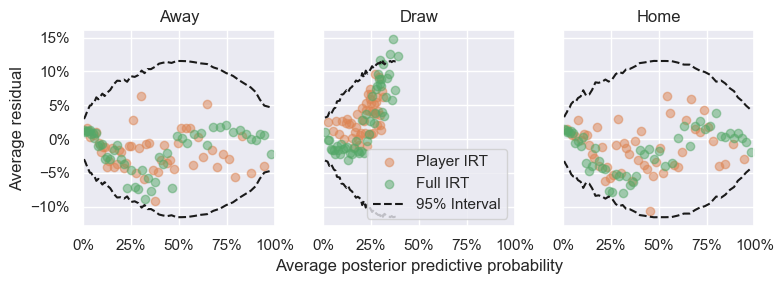

In [119]:
fig, axes = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT)
)

for outcome, ax in zip(OUTCOMES, axes):
    bins = qcut(post_pct["player"][outcome.capitalize()].to_pandas(), bins=50)
    resid_df = binned_resid(
        bins, votes_pct[f"{outcome.lower()}_votes"], post_pct["player"][outcome]
    )

    ax.scatter(
        resid_df["bin"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df["bin"],
        marker="o",
        alpha=0.5,
        c="C1",
        label="Player IRT",
    )

    bins = qcut(post_pct["full"][outcome.capitalize()].to_pandas(), bins=50)
    resid_df = binned_resid(
        bins, votes_pct[f"{outcome.lower()}_votes"], post_pct["full"][outcome]
    )

    ax.scatter(
        resid_df["bin"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df["bin"],
        marker="o",
        alpha=0.5,
        c="C2",
        label="Full IRT",
    )

    ax.plot(
        resid_df["bin"], 2 * resid_df["stderr"], c="k", ls="--", label="95% Interval"
    )
    ax.plot(resid_df["bin"], -2 * resid_df["stderr"], c="k", ls="--")

    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(pct_formatter())
    ax.xaxis.set_major_locator(pct_locator)

    ax.set_title(outcome)

axes[1].set_xlabel("Average posterior predictive probability")

axes[0].yaxis.set_major_formatter(pct_formatter())
axes[0].set_ylabel("Average residual")

axes[1].legend(loc="lower right")

fig.tight_layout()

Again most of the binned residuals lie within the 95% intervals, but this model also systematically underestimates the probability of a draw.

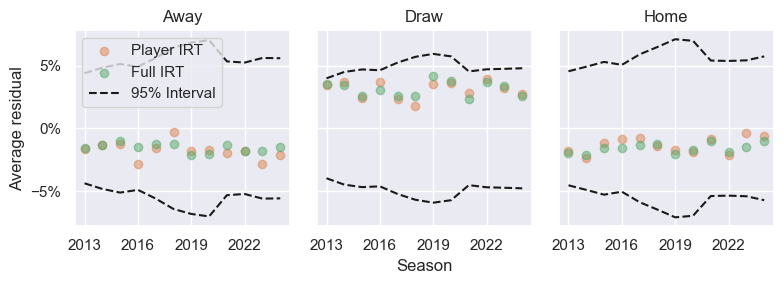

In [120]:
fig, axes = plt.subplots(
    ncols=3, sharex=True, sharey=True, figsize=(FIG_WIDTH, 0.5 * FIG_HEIGHT)
)

for outcome, ax in zip(OUTCOMES, axes):
    resid_df = binned_resid(
        df["season_start"],
        votes_pct[f"{outcome.lower()}_votes"],
        post_pct["player"][outcome],
    )

    ax.scatter(
        resid_df["season_start"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df[outcome.capitalize()],
        marker="o",
        alpha=0.5,
        c="C1",
        label="Player IRT",
    )

    resid_df = binned_resid(
        df["season_start"],
        votes_pct[f"{outcome.lower()}_votes"],
        post_pct["full"][outcome],
    )

    ax.scatter(
        resid_df["season_start"],
        resid_df[f"{outcome.lower()}_votes"] - resid_df[outcome.capitalize()],
        marker="o",
        alpha=0.5,
        c="C2",
        label="Full IRT",
    )

    ax.plot(
        resid_df["season_start"],
        2 * resid_df["stderr"],
        c="k",
        ls="--",
        label="95% Interval",
    )
    ax.plot(resid_df["season_start"], -2 * resid_df["stderr"], c="k", ls="--")

    ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

    ax.set_title(outcome)

axes[1].set_xlabel("Season")

axes[0].yaxis.set_major_formatter(pct_formatter())
axes[0].set_ylabel("Average residual")

axes[0].legend(loc="upper left")

fig.tight_layout()

We see rather similar residuals here as well.

#### Model comparison

We again compare all the models based on their ELPD.

In [121]:
traces["Full"] = full_trace

In [122]:
comp_df = az.compare(traces)

In [123]:
comp_df.loc[:, :"dse"]

rank       elpd_loo         p_loo     elpd_diff    weight  \
Full            0  -49087.065538  14575.134152      0.000000  0.752006   
Player          1  -79655.697628  16007.723013  30568.632090  0.163252   
Team            2 -114219.291260   3571.764768  65132.225722  0.034545   
Season/home     3 -116386.899798    699.909390  67299.834260  0.016006   
Home            4 -116638.459291     71.367693  67551.393753  0.008296   
No Home         5 -117051.931167     18.674791  67964.865630  0.025895   

                      se          dse  
Full          941.338203     0.000000  
Player       1412.708937  1254.896848  
Team         1667.424200  1698.340002  
Season/home  1745.596783  1775.770173  
Home         1732.718135  1760.020293  
No Home      1749.585706  1771.739869

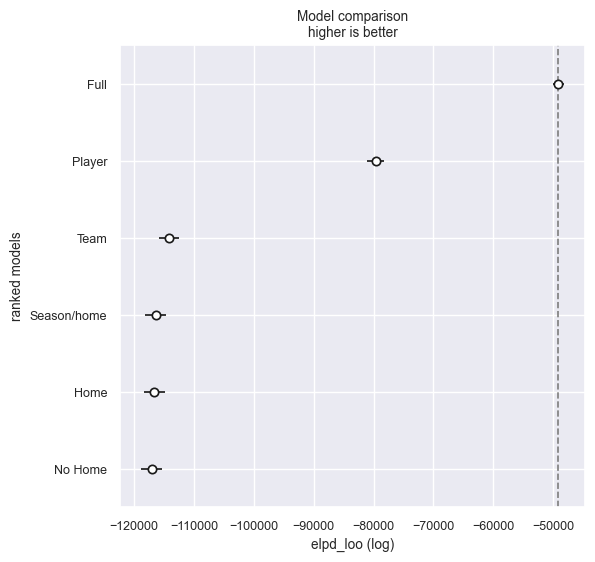

In [124]:
az.plot_compare(comp_df, insample_dev=False, plot_ic_diff=False, textsize=9);

We see that the Full IRT model is about as much an improvement over the Player IRT model as that model was an improvement over the Team IRT model.

With this best-performing model in hand, we are ready to answer our motivating questions.

#### Interpretation

##### Is fighting a skill?

To answer this question, we visualize the posterior distributions of the inter-season correlations $\rho_{\beta}$, $\rho_{\beta^{\text{home}}}$, and $\rho_{\theta}$.

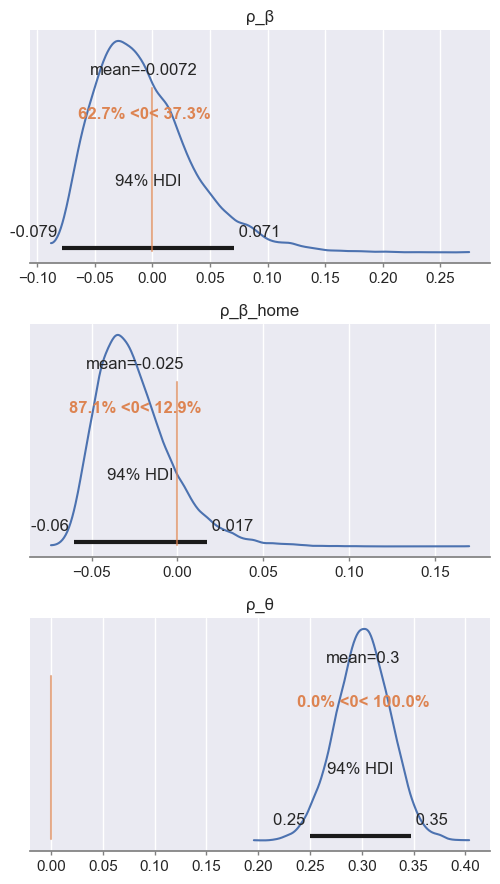

In [125]:
ax, *_ = az.plot_posterior(
    full_trace,
    var_names="^ρ.*[^_]$",
    filter_vars="regex",
    ref_val=0,
    grid=(3, 1),
    figsize=(0.65 * FIG_WIDTH, 1.5 * FIG_HEIGHT),
)

ax.figure.tight_layout();

We see that the high posterior density intervals for $\rho_{\beta}$ and $\rho_{\beta^{\text{home}}}$ both comfortably contain zero, while the posterior distribution of $\rho_{\theta}$ is quite separated from it.

These posterior distributions indicate that there is no team-level fighting skill (at least not one that is sustained season-over-season), but that there is player-level skill.  This is an exciting, if not entirely surprising result.

##### Team "skill"

Here we put "skill" back in quotes as we have just shown that teams do not, in fact, possess measurable, repeatable skill.  We visualize the latent team "skills" $\beta_k$ and $\beta_k^{\text{home}}$.

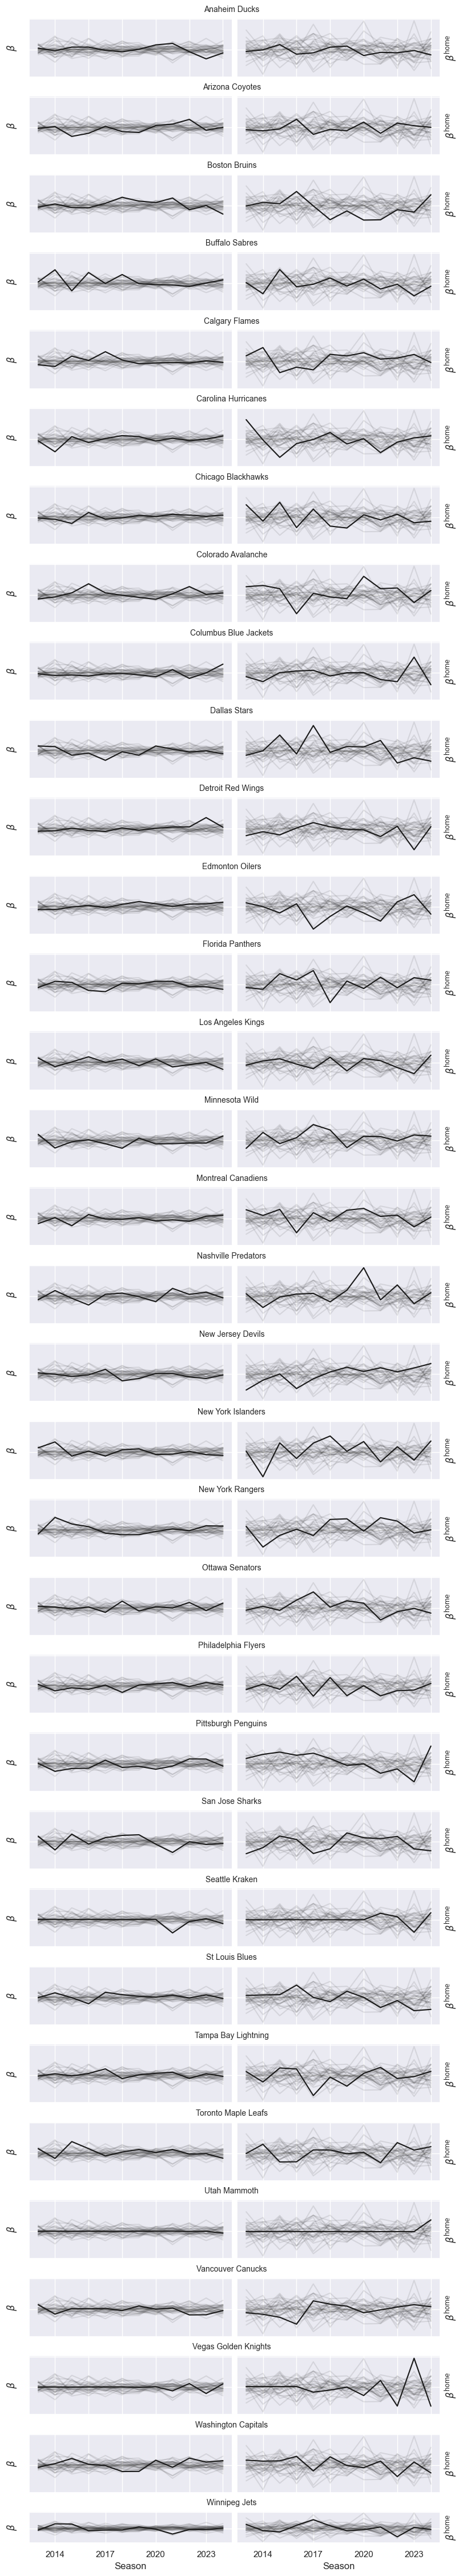

In [126]:
fig = plt.figure(figsize=(FIG_WIDTH, 7.5 * FIG_HEIGHT), layout="constrained")
team_figs = fig.subfigures(nrows=n_team)

for team, team_fig in zip(teams.categories, team_figs):
    β_ax, β_home_ax = team_fig.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
    β_ax.plot(
        seasons,
        full_trace.posterior["β"].mean(dim=("chain", "draw")).T,
        c="k",
        alpha=0.1,
    )
    β_ax.plot(
        seasons,
        full_trace.posterior["β"].sel(team=team).mean(dim=("chain", "draw")).T,
        c="k",
    )

    if team != teams.categories[-1]:
        β_ax.set_xticklabels([])

    β_ax.set_yticklabels([])
    β_ax.set_ylabel(r"$\beta$")

    β_home_ax.plot(
        seasons,
        full_trace.posterior["β_home"].mean(dim=("chain", "draw")).T,
        c="k",
        alpha=0.1,
    )
    β_home_ax.plot(
        seasons,
        full_trace.posterior["β_home"].sel(team=team).mean(dim=("chain", "draw")).T,
        c="k",
    )

    β_home_ax.yaxis.set_label_position("right")
    β_home_ax.set_ylabel(r"$\beta^{\text{home}}$")

    team_fig.suptitle(team, size="small")

β_ax.xaxis.set_major_locator(season_locator)
β_ax.set_xlabel("Season")

β_home_ax.set_xlabel("Season");

We see here that no team's latent skill values show consistency season-over-season, in line with the fact that the posterior distributions of their correlations are concentrated around zero.

##### Player skill

Note that we do not quote the word _skill_ in this section.  Below we visualize the top and bottom players according to the latent skill encoded in $\theta$.

In [127]:
θ_sorted_players = players.categories[
    full_trace.posterior["θ"].mean(dim=("chain", "draw", "season")).argsort().to_numpy()
]

In [128]:
def top_and_bottom(s, *, n=5):
    return pl.concat((s[-n:][::-1], s[:n][::-1]))

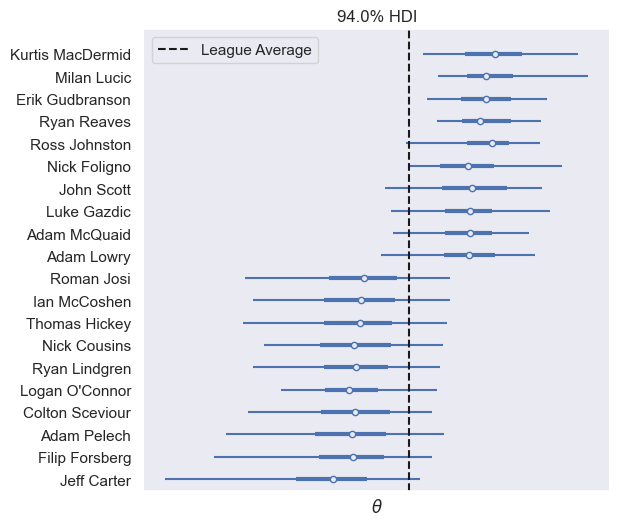

In [129]:
(ax,) = az.plot_forest(
    full_trace,
    var_names="θ",
    coords={"player": top_and_bottom(θ_sorted_players, n=10)},
    combined=True,
    combine_dims={"season"},
    labeller=az.labels.NoVarLabeller(),
)

ax.axvline(0, c="k", ls="--", label="League Average")

ax.set_xticks([])
ax.set_xlabel(r"$\theta$")

ax.legend(loc="upper left");

Noted tough guys Kurtis MacDermid and Milan Lucic top the list, and any long-suffering Flyers fan (like myself) will attest that Jeff Carter belongs toward the bottom.

### Future directions

In the future I would like to improve this model to be correctly calibrated in terms of its predictions of draw probability.  It would also be interesting to explore what the [aging curve](https://library.fangraphs.com/the-beginners-guide-to-aging-curves/) of player fighting ability looks like.

I'd like to conclude this post by again extending my sincere thanks to the administrators of hockeyfights.com for gathering such an interesting dataset.

This post is available as a Jupyer notebook [here](https://nbviewer.org/gist/AustinRochford/e99bdce77e8a083958291b2be01d0bd2).

In [130]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sun Nov 09 2025

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

seaborn   : 0.13.2
polars    : 1.14.0
numpy     : 1.26.4
pandas    : 2.2.3
pymc      : 5.25.1
arviz     : 0.20.0
matplotlib: 3.9.2
numba     : 0.60.0
nutpie    : 0.15.2
pytensor  : 2.31.7

